# Èü≥Ê•Ω„É©„Éô„É™„É≥„Ç∞ÔºöÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Self-Attention „É¢„Éá„É´
## ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ + AttentionÊ©üÊßã„ÅßÊôÇÁ≥ªÂàó„Éá„Éº„Çø„Å´ÁâπÂåñ„Åó„ÅüÈü≥Ê•ΩÂàÜÈ°û
test_5„Çí„Éô„Éº„Çπ„Å´„ÄÅÊôÇÁ≥ªÂàóÂá¶ÁêÜ„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„ÅüAttentionÊ©üÊßã‰ªò„ÅçResNet„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£„ÇíÂÆüË£Ö

In [1]:
# ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Self-AttentionÈü≥Ê•ΩÂàÜÈ°û
# ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ + „Éû„É´„ÉÅ„Éò„ÉÉ„Éâ„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥ + ÊôÇÁ≥ªÂàóÁâπÂåñË®≠Ë®à

import pandas as pd
import numpy as np
import librosa
import librosa.feature
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, 
    GlobalAveragePooling2D, GlobalAveragePooling1D, BatchNormalization, Add, 
    Input, Activation, Concatenate, MultiHeadAttention, LayerNormalization,
    Reshape, Permute, Lambda, Attention, AdditiveAttention
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# GPUË®≠ÂÆö
print("=== GPUË®≠ÂÆöÈñãÂßã ===")
physical_devices = tf.config.list_physical_devices()
gpu_devices = tf.config.list_physical_devices('GPU')

print(f"Âà©Áî®ÂèØËÉΩ„Éá„Éê„Ç§„Çπ: {physical_devices}")
print(f"GPU „Éá„Éê„Ç§„Çπ: {gpu_devices}")

if gpu_devices:
    try:
        # GPU „É°„É¢„É™ÂãïÁöÑÊã°Âºµ„ÇíÊúâÂäπÂåñ
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("‚úÖ GPUÊ§úÂá∫„Éª„É°„É¢„É™ÂãïÁöÑÊã°Âºµ„ÇíÊúâÂäπÂåñ„Åó„Åæ„Åó„Åü")
        print(f"GPUÂêç: {gpu_devices[0].name}")

        # Á∞°Âçò„Å™Âãï‰Ωú„ÉÜ„Çπ„Éà
        with tf.device('/GPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            test_result = tf.matmul(test_tensor, test_tensor)
        print(f"GPUÂãï‰Ωú„ÉÜ„Çπ„ÉàÊàêÂäü: {test_result.device}")

    except RuntimeError as e:
        print(f"‚ö†Ô∏è GPUË®≠ÂÆö„Ç®„É©„Éº: {e}")
        print("CPU„É¢„Éº„Éâ„ÅßÁ∂ôÁ∂ö„Åó„Åæ„Åô")
else:
    print("‚ö†Ô∏è GPUÊú™Ê§úÂá∫ - CPU„É¢„Éº„Éâ„ÅßÂÆüË°å")

print("=== GPUË®≠ÂÆöÂÆå‰∫Ü ===\n")

print("ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Attention „É©„Ç§„Éñ„É©„É™Ë™≠„ÅøËæº„ÅøÂÆå‰∫Ü")
print(f"TensorFlow „Éê„Éº„Ç∏„Éß„É≥: {tf.__version__}")
print(f"Librosa „Éê„Éº„Ç∏„Éß„É≥: {librosa.__version__}")
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {'GPU' if gpu_devices else 'CPU'}")

2025-09-30 14:46:28.666905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 14:46:28.969049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759211189.098198   73973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759211189.128294   73973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-30 14:46:29.384152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

=== GPUË®≠ÂÆöÈñãÂßã ===
Âà©Áî®ÂèØËÉΩ„Éá„Éê„Ç§„Çπ: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU „Éá„Éê„Ç§„Çπ: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
‚úÖ GPUÊ§úÂá∫„Éª„É°„É¢„É™ÂãïÁöÑÊã°Âºµ„ÇíÊúâÂäπÂåñ„Åó„Åæ„Åó„Åü
GPUÂêç: /physical_device:GPU:0
GPUÂãï‰Ωú„ÉÜ„Çπ„ÉàÊàêÂäü: /job:localhost/replica:0/task:0/device:GPU:0
=== GPUË®≠ÂÆöÂÆå‰∫Ü ===

ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Attention „É©„Ç§„Éñ„É©„É™Ë™≠„ÅøËæº„ÅøÂÆå‰∫Ü
TensorFlow „Éê„Éº„Ç∏„Éß„É≥: 2.18.0
Librosa „Éê„Éº„Ç∏„Éß„É≥: 0.11.0
‰ΩøÁî®„Éá„Éê„Ç§„Çπ: GPU


I0000 00:00:1759211215.457162   73973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21742 MB memory:  -> device: 0, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:16:00.0, compute capability: 8.9


In [2]:
# „É°„Çø„Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("=== Èü≥Ê•Ω„Ç∏„É£„É≥„É´„É©„Éô„É´ ===")
for i, genre in label_list.items():
    print(f"{i}: {genre}")
print(f"\nË®ìÁ∑¥„Éá„Éº„ÇøÁ∑èÊï∞: {len(train_master)}")
print(f"ÂêÑ„ÇØ„É©„Çπ„ÅÆ„Éá„Éº„ÇøÊï∞: {train_master['label_id'].value_counts().iloc[0]}")

=== Èü≥Ê•Ω„Ç∏„É£„É≥„É´„É©„Éô„É´ ===
0: blues
1: classical
2: country
3: disco
4: hiphop
5: jazz
6: metal
7: pop
8: reggae
9: rock

Ë®ìÁ∑¥„Éá„Éº„ÇøÁ∑èÊï∞: 500
ÂêÑ„ÇØ„É©„Çπ„ÅÆ„Éá„Éº„ÇøÊï∞: 50


In [3]:
# ÊôÇÁ≥ªÂàó„Å´ÁâπÂåñ„Åó„ÅüÈ´òÂ∫¶„Å™„Éá„Éº„ÇøÊã°ÂºµÈñ¢Êï∞
def add_white_noise(audio, noise_factor=0.005):
    """„Éõ„ÉØ„Ç§„Éà„Éé„Ç§„Ç∫„ÇíËøΩÂä†"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """ÊôÇÈñìËª∏ÊñπÂêë„ÅÆ„Ç∑„Éï„Éà"""
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    if shift > 0:
        augmented_audio = np.r_[audio[shift:], np.zeros(shift)]
    else:
        augmented_audio = np.r_[np.zeros(-shift), audio[:shift]]
    return augmented_audio

def time_stretch(audio, rate=None):
    """ÊôÇÈñì„Çπ„Éà„É¨„ÉÉ„ÉÅÔºàÈÄüÂ∫¶Â§âÊõ¥Ôºâ"""
    if rate is None:
        rate = np.random.uniform(0.85, 1.15)
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps=None):
    """„Éî„ÉÉ„ÉÅ„Ç∑„Éï„Éà"""
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)  # ¬±2ÂçäÈü≥
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

def spectral_rolloff_augment(audio, sr):
    """„Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„Éï„Å´„Çà„ÇãÈü≥Ë≥™Â§âÂåñ"""
    # È´òÂë®Ê≥¢ÊàêÂàÜ„Çí„É©„É≥„ÉÄ„É†„Å´Ê∏õË°∞
    rolloff_freq = np.random.uniform(2000, 8000)
    # „Éï„Ç£„É´„Çø„É™„É≥„Ç∞Âá¶ÁêÜÔºàÁ∞°Áï•ÂåñÔºâ
    stft = librosa.stft(audio)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0]*2-1)
    mask = freqs > rolloff_freq
    stft[mask] *= np.random.uniform(0.1, 0.5)
    augmented_audio = librosa.istft(stft)
    return augmented_audio

print("ÊôÇÁ≥ªÂàóÁâπÂåñ„Éá„Éº„ÇøÊã°ÂºµÈñ¢Êï∞„ÇíÂÆöÁæ©ÂÆå‰∫ÜÔºà„Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„ÉïËøΩÂä†Ôºâ")

ÊôÇÁ≥ªÂàóÁâπÂåñ„Éá„Éº„ÇøÊã°ÂºµÈñ¢Êï∞„ÇíÂÆöÁæ©ÂÆå‰∫ÜÔºà„Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„ÉïËøΩÂä†Ôºâ


In [4]:
# ÊôÇÁ≥ªÂàó„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„Åü„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫Èñ¢Êï∞
def extract_temporal_multi_features(audio, sr, n_mfcc=13, n_mels=128, max_len=1320):
    """ÊôÇÁ≥ªÂàó„Å´ÁâπÂåñ„Åó„Åü4Á®ÆÈ°û„ÅÆÈü≥ÈüøÁâπÂæ¥Èáè„ÇíÊäΩÂá∫Ôºàmax_lenÊã°ÂºµÔºâ"""
    
    # 1. MelspectrogramÔºà„Çà„ÇäÈ´òËß£ÂÉèÂ∫¶Ôºâ
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=512, n_fft=2048
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCCÔºàÊôÇÁ≥ªÂàóÈáçË¶ñÔºâ
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=512, n_fft=2048
    )
    
    # 3. MFCC Delta (1Ê¨°ÂæÆÂàÜ) - ÊôÇÈñìÂ§âÂåñ„ÅÆÈÄüÂ∫¶
    mfcc_delta = librosa.feature.delta(mfccs, width=9, order=1)
    
    # 4. MFCC Delta-Delta (2Ê¨°ÂæÆÂàÜ) - ÊôÇÈñìÂ§âÂåñ„ÅÆÂä†ÈÄüÂ∫¶
    mfcc_delta2 = librosa.feature.delta(mfccs, width=9, order=2)
    
    # ÊôÇÁ≥ªÂàóÈï∑„ÇíÁµ±‰∏ÄÔºà„Çº„É≠„Éë„Éá„Ç£„É≥„Ç∞/„Éà„É™„Éü„É≥„Ç∞Ôºâ
    features = [mel_spec_db, mfccs, mfcc_delta, mfcc_delta2]
    processed_features = []
    
    for feature in features:
        if feature.shape[1] < max_len:
            # ÂâçÂæå„Å´„Éë„Éá„Ç£„É≥„Ç∞Ôºà„Çà„ÇäËá™ÁÑ∂Ôºâ
            pad_width = max_len - feature.shape[1]
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            feature = np.pad(feature, ((0, 0), (pad_left, pad_right)), mode='reflect')
        else:
            # ‰∏≠Â§ÆÈÉ®ÂàÜ„ÇíÊäΩÂá∫Ôºà„Çà„ÇäÊÉÖÂ†±Èáè„ÅåÂ§ö„ÅÑÔºâ
            start = (feature.shape[1] - max_len) // 2
            feature = feature[:, start:start + max_len]
        processed_features.append(feature)
    
    return processed_features

def create_temporal_4channel_input(features_list):
    """ÊôÇÁ≥ªÂàóÊÉÖÂ†±„Çí‰øùÊåÅ„Åô„Çã4„ÉÅ„É£„É≥„Éç„É´ÂÖ•Âäõ„Çí‰ΩúÊàê"""
    mel_spec, mfcc, mfcc_delta, mfcc_delta2 = features_list
    
    # MFCC„Çí128Ê¨°ÂÖÉ„Å´„Ç¢„ÉÉ„Éó„Çµ„É≥„Éó„É™„É≥„Ç∞Ôºà„Çà„ÇäË©≥Á¥∞„Å™ÊÉÖÂ†±‰øùÊåÅÔºâ
    from scipy.interpolate import interp1d
    
    def upsample_feature(feature, target_dim):
        x_old = np.linspace(0, 1, feature.shape[0])
        x_new = np.linspace(0, 1, target_dim)
        upsampled = np.zeros((target_dim, feature.shape[1]))
        for i in range(feature.shape[1]):
            f = interp1d(x_old, feature[:, i], kind='cubic', fill_value='extrapolate')
            upsampled[:, i] = f(x_new)
        return upsampled
    
    mfcc_upsampled = upsample_feature(mfcc, 128)
    mfcc_delta_upsampled = upsample_feature(mfcc_delta, 128)
    mfcc_delta2_upsampled = upsample_feature(mfcc_delta2, 128)
    
    # 4„ÉÅ„É£„É≥„Éç„É´„Å®„Åó„Å¶ÁµêÂêàÔºàÊôÇÁ≥ªÂàóÊ¨°ÂÖÉ„Çí‰øùÊåÅÔºâ
    four_channel = np.stack([
        mel_spec,                # Channel 0: Âë®Ê≥¢Êï∞-ÊôÇÈñìÁâπÂæ¥
        mfcc_upsampled,         # Channel 1: „Ç±„Éó„Çπ„Éà„É©„É´ÁâπÂæ¥  
        mfcc_delta_upsampled,   # Channel 2: ÊôÇÈñìÂ§âÂåñÈÄüÂ∫¶
        mfcc_delta2_upsampled   # Channel 3: ÊôÇÈñìÂ§âÂåñÂä†ÈÄüÂ∫¶
    ], axis=-1)
    
    return four_channel

print("ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫Èñ¢Êï∞„ÇíÂÆöÁæ©ÂÆå‰∫Ü")
print("ÊîπÂñÑÁÇπ:")
print("  ‚úì max_len=1320 (100%„Éá„Éº„Çø‰øùÊåÅ)")
print("  ‚úì ‰∏≠Â§ÆÈÉ®ÂàÜÊäΩÂá∫ÔºàÊÉÖÂ†±ÈáèÊúÄÂ§ßÂåñÔºâ")
print("  ‚úì Reflect„Éë„Éá„Ç£„É≥„Ç∞Ôºà„Çà„ÇäËá™ÁÑ∂Ôºâ")
print("  ‚úì Cubic„Ç¢„ÉÉ„Éó„Çµ„É≥„Éó„É™„É≥„Ç∞ÔºàÈ´òÂìÅË≥™Ôºâ")
print("  ‚úì „Çà„ÇäÈ´òËß£ÂÉèÂ∫¶hop_length=512")

ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫Èñ¢Êï∞„ÇíÂÆöÁæ©ÂÆå‰∫Ü
ÊîπÂñÑÁÇπ:
  ‚úì max_len=1320 (100%„Éá„Éº„Çø‰øùÊåÅ)
  ‚úì ‰∏≠Â§ÆÈÉ®ÂàÜÊäΩÂá∫ÔºàÊÉÖÂ†±ÈáèÊúÄÂ§ßÂåñÔºâ
  ‚úì Reflect„Éë„Éá„Ç£„É≥„Ç∞Ôºà„Çà„ÇäËá™ÁÑ∂Ôºâ
  ‚úì Cubic„Ç¢„ÉÉ„Éó„Çµ„É≥„Éó„É™„É≥„Ç∞ÔºàÈ´òÂìÅË≥™Ôºâ
  ‚úì „Çà„ÇäÈ´òËß£ÂÉèÂ∫¶hop_length=512


In [5]:
# Self-AttentionÊ©üÊßã„ÅÆÂÆüË£Ö
def multi_head_self_attention_block(inputs, num_heads=8, key_dim=64, dropout_rate=0.1):
    """„Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑèÊ©üÊßã„Éñ„É≠„ÉÉ„ÇØ"""
    # Multi-Head Self-Attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout_rate
    )(inputs, inputs)
    
    # Add & Norm
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed Forward Network
    ffn_dim = inputs.shape[-1] * 4
    ffn_output = Dense(ffn_dim, activation='relu')(attention_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    # Add & Norm
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    
    return ffn_output

def temporal_attention_pooling(inputs, attention_dim=256):
    """ÊôÇÁ≥ªÂàó„Å´ÁâπÂåñ„Åó„Åü„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞"""
    # ÊôÇÈñìÊ¨°ÂÖÉ„Å´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥Èáç„Åø„ÇíË®àÁÆó
    attention_weights = Dense(attention_dim, activation='tanh')(inputs)
    attention_weights = Dense(1, activation='softmax')(attention_weights)
    
    # Èáç„Åø‰ªò„ÅçÂπ≥Âùá
    attended_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([inputs, attention_weights])
    
    return attended_output

print("Self-AttentionÊ©üÊßã„Å®„ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞„ÇíÂÆöÁæ©ÂÆå‰∫Ü")

Self-AttentionÊ©üÊßã„Å®„ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞„ÇíÂÆöÁæ©ÂÆå‰∫Ü


In [6]:
# ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£
def temporal_residual_block(x, filters, kernel_size=(3, 3), stride=1, conv_shortcut=False):
    """ÊôÇÁ≥ªÂàó„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„ÅüÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ"""
    
    if conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x if stride == 1 else MaxPooling2D(stride, stride, padding='same')(x)
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
    # ÊôÇÁ≥ªÂàó„ÇíÈáçË¶ñ„Åó„Åü„Ç´„Éº„Éç„É´„Çµ„Ç§„Ç∫ÔºàÊôÇÈñìËª∏„ÇíÈï∑„ÅèÔºâ
    x = Conv2D(filters, (3, 5), strides=stride, padding='same')(x)  # (freq, time)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 5), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_temporal_resnet_attention_model(input_shape=(128, 1320, 4), num_classes=10):
    """ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„É¢„Éá„É´"""
    inputs = Input(shape=input_shape)
    
    # === Phase 1: ÂàùÊúüÁâπÂæ¥ÊäΩÂá∫ ===
    # ÊôÇÁ≥ªÂàó„ÇíËÄÉÊÖÆ„Åó„ÅüÂàùÊúüÁï≥„ÅøËæº„ÅøÔºàÊôÇÈñìËª∏‰øùÊåÅÔºâ
    x = Conv2D(64, (7, 11), strides=(2, 2), padding='same')(inputs)  # ÊôÇÈñìËª∏„ÇíÂ§ö„ÅèÊÆã„Åô
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # === Phase 2: ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØÁæ§ ===
    # Stage 1: Ë©≥Á¥∞ÁâπÂæ¥ÊäΩÂá∫
    x = temporal_residual_block(x, 64)
    x = temporal_residual_block(x, 64)
    x = temporal_residual_block(x, 64)
    
    # Stage 2: ‰∏≠ÈñìÁâπÂæ¥ÊäΩÂá∫  
    x = temporal_residual_block(x, 128, stride=2, conv_shortcut=True)
    x = temporal_residual_block(x, 128)
    x = temporal_residual_block(x, 128)
    
    # Stage 3: È´ò„É¨„Éô„É´ÁâπÂæ¥ÊäΩÂá∫
    x = temporal_residual_block(x, 256, stride=2, conv_shortcut=True)
    x = temporal_residual_block(x, 256)
    
    # === Phase 3: 2D‚Üí1DÂ§âÊèõÔºàÊôÇÁ≥ªÂàó„Éï„Ç©„Éº„Ç´„ÇπÔºâ===
    # Âë®Ê≥¢Êï∞Ê¨°ÂÖÉ„ÇíÁµ±Âêà„Åó„Å¶ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„Å´Â§âÊèõ
    shape_before_flatten = x.shape
    x = GlobalAveragePooling2D()(x)  # ‰∏ÄÊôÇÁöÑ„Å´Á©∫ÈñìÊ¨°ÂÖÉ„ÇíÂâäÊ∏õ
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # ÊôÇÁ≥ªÂàóÁî®„Å´ÂÜçÊßãÊàêÔºàÊì¨‰ººÁöÑ„Å™ÊôÇÁ≥ªÂàóË°®ÁèæÔºâ
    temporal_length = 64  # ÊôÇÁ≥ªÂàó„ÅÆÈï∑„Åï
    feature_dim = 512 // temporal_length * temporal_length
    x = Dense(feature_dim, activation='relu')(x)
    x = Reshape((temporal_length, feature_dim // temporal_length))(x)
    
    # === Phase 4: Self-Attention Â±§Áæ§ ===
    # Ë§áÊï∞„ÅÆAttention„Éñ„É≠„ÉÉ„ÇØ
    x = multi_head_self_attention_block(x, num_heads=8, key_dim=64, dropout_rate=0.1)
    x = multi_head_self_attention_block(x, num_heads=8, key_dim=64, dropout_rate=0.1)
    x = multi_head_self_attention_block(x, num_heads=4, key_dim=32, dropout_rate=0.1)
    
    # === Phase 5: „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞ ===
    x = temporal_attention_pooling(x, attention_dim=256)
    
    # === Phase 6: ÊúÄÁµÇÂàÜÈ°ûÂ±§ ===
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

print("ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£„ÇíÂÆöÁæ©ÂÆå‰∫Ü")
print("ÁâπÂæ¥:")
print("  ‚úì ÊôÇÈñìËª∏ÈáçË¶ñ„Ç´„Éº„Éç„É´ (3, 5)")
print("  ‚úì 3Â±§Self-Attention„Éñ„É≠„ÉÉ„ÇØ")
print("  ‚úì „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞")
print("  ‚úì 6ÊÆµÈöéÁâπÂæ¥ÊäΩÂá∫„Éë„Ç§„Éó„É©„Ç§„É≥")
print("  ‚úì ResNetÊÆãÂ∑ÆÊé•Á∂ö + TransformerÊ≥®ÊÑèÊ©üÊßã")

ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£„ÇíÂÆöÁæ©ÂÆå‰∫Ü
ÁâπÂæ¥:
  ‚úì ÊôÇÈñìËª∏ÈáçË¶ñ„Ç´„Éº„Éç„É´ (3, 5)
  ‚úì 3Â±§Self-Attention„Éñ„É≠„ÉÉ„ÇØ
  ‚úì „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞
  ‚úì 6ÊÆµÈöéÁâπÂæ¥ÊäΩÂá∫„Éë„Ç§„Éó„É©„Ç§„É≥
  ‚úì ResNetÊÆãÂ∑ÆÊé•Á∂ö + TransformerÊ≥®ÊÑèÊ©üÊßã


In [9]:
# Êã°Âºµ„Åï„Çå„Åü„Éû„É´„ÉÅÁâπÂæ¥ÈáèË®ìÁ∑¥„Éá„Éº„Çø„ÅÆ‰ΩúÊàêÔºàÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñÁâàÔºâ
train_files = natsorted(glob.glob('train_sound/train_*.au'))
print(f"ÂÖÉ„ÅÆË®ìÁ∑¥„Éï„Ç°„Ç§„É´Êï∞: {len(train_files)}")

X_train_temporal = []
y_train_temporal = []

print("ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥Èáè„Éá„Éº„ÇøÊã°ÂºµÂá¶ÁêÜ„ÇíÈñãÂßã...")
print("Êã°ÂºµÊâãÊ≥ï: ÂÖÉ„Éá„Éº„Çø + „Éõ„ÉØ„Ç§„Éà„Éé„Ç§„Ç∫ + ÊôÇÈñì„Ç∑„Éï„Éà + ÊôÇÈñì„Çπ„Éà„É¨„ÉÉ„ÉÅ + „Éî„ÉÉ„ÉÅ„Ç∑„Éï„Éà + „Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„Éï")

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"Âá¶ÁêÜ‰∏≠: {i}/{len(train_files)} ({i/len(train_files)*100:.1f}%)")
    
    try:
        # ÂÖÉ„ÅÆÈü≥Â£∞„Éá„Éº„Çø„ÇíË™≠„ÅøËæº„Åø
        y, sr = librosa.load(file_path)
        file_index = int(file_path.split('_')[-1].split('.')[0])
        label = train_master.iloc[file_index]['label_id']
        
        # ÂêÑÁ®ÆÊã°Âºµ„Éá„Éº„Çø„Å®ÁâπÂæ¥ÈáèÊäΩÂá∫
        augmentations = [
            ('original', y),
            ('noise', add_white_noise(y)),
            ('shift', time_shift(y)),
            ('stretch', time_stretch(y)),
            ('pitch', pitch_shift(y, sr)),
            ('spectral', spectral_rolloff_augment(y, sr))
        ]
        
        for aug_name, audio_data in augmentations:
            # ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫
            features = extract_temporal_multi_features(audio_data, sr, max_len=1320)
            four_channel_data = create_temporal_4channel_input(features)
            
            X_train_temporal.append(four_channel_data)
            y_train_temporal.append(label)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_train = np.array(X_train_temporal)
y_train = np.array(y_train_temporal)

print(f"\n=== ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥Èáè„Éá„Éº„Çø‰ΩúÊàêÂÆå‰∫Ü ===") 
print(f"Êã°ÂºµÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„ÇøÂΩ¢Áä∂: {X_train.shape}")
print(f"Êã°ÂºµÂæå„ÅÆ„É©„Éô„É´ÂΩ¢Áä∂: {y_train.shape}")
print(f"„Éá„Éº„ÇøÊã°ÂºµÁéá: {len(y_train_temporal) / len(train_files):.1f}ÂÄç")
print(f"ÊôÇÁ≥ªÂàóÈï∑: {X_train.shape[2]} „Éï„É¨„Éº„É† (Á¥Ñ{X_train.shape[2]*512/22050:.1f}Áßí)")
print(f"„ÉÅ„É£„É≥„Éç„É´Êï∞: {X_train.shape[-1]} (Mel + MFCC + Delta + Delta-Delta)")
print(f"ÁâπÂæ¥ÈáèËß£ÂÉèÂ∫¶: {X_train.shape[1]} x {X_train.shape[2]}")

ÂÖÉ„ÅÆË®ìÁ∑¥„Éï„Ç°„Ç§„É´Êï∞: 500
ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥Èáè„Éá„Éº„ÇøÊã°ÂºµÂá¶ÁêÜ„ÇíÈñãÂßã...
Êã°ÂºµÊâãÊ≥ï: ÂÖÉ„Éá„Éº„Çø + „Éõ„ÉØ„Ç§„Éà„Éé„Ç§„Ç∫ + ÊôÇÈñì„Ç∑„Éï„Éà + ÊôÇÈñì„Çπ„Éà„É¨„ÉÉ„ÉÅ + „Éî„ÉÉ„ÉÅ„Ç∑„Éï„Éà + „Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„Éï
Âá¶ÁêÜ‰∏≠: 0/500 (0.0%)
Âá¶ÁêÜ‰∏≠: 50/500 (10.0%)
Âá¶ÁêÜ‰∏≠: 100/500 (20.0%)
Âá¶ÁêÜ‰∏≠: 150/500 (30.0%)
Âá¶ÁêÜ‰∏≠: 200/500 (40.0%)
Âá¶ÁêÜ‰∏≠: 250/500 (50.0%)
Âá¶ÁêÜ‰∏≠: 300/500 (60.0%)
Âá¶ÁêÜ‰∏≠: 350/500 (70.0%)
Âá¶ÁêÜ‰∏≠: 400/500 (80.0%)
Âá¶ÁêÜ‰∏≠: 450/500 (90.0%)

=== ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥Èáè„Éá„Éº„Çø‰ΩúÊàêÂÆå‰∫Ü ===
Êã°ÂºµÂæå„ÅÆË®ìÁ∑¥„Éá„Éº„ÇøÂΩ¢Áä∂: (3000, 128, 1320, 4)
Êã°ÂºµÂæå„ÅÆ„É©„Éô„É´ÂΩ¢Áä∂: (3000,)
„Éá„Éº„ÇøÊã°ÂºµÁéá: 6.0ÂÄç
ÊôÇÁ≥ªÂàóÈï∑: 1320 „Éï„É¨„Éº„É† (Á¥Ñ30.7Áßí)
„ÉÅ„É£„É≥„Éç„É´Êï∞: 4 (Mel + MFCC + Delta + Delta-Delta)
ÁâπÂæ¥ÈáèËß£ÂÉèÂ∫¶: 128 x 1320


In [10]:
# „ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÂá¶ÁêÜ
test_files = natsorted(glob.glob('test_sound/test_*.au'))
print(f"„ÉÜ„Çπ„Éà„Éï„Ç°„Ç§„É´Êï∞: {len(test_files)}")

X_test_temporal = []

print("„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫‰∏≠...")
for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"Âá¶ÁêÜ‰∏≠: {i}/{len(test_files)} ({i/len(test_files)*100:.1f}%)")
    
    try:
        y, sr = librosa.load(file_path)
        features = extract_temporal_multi_features(y, sr, max_len=1320)
        four_channel_data = create_temporal_4channel_input(features)
        X_test_temporal.append(four_channel_data)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_test = np.array(X_test_temporal)
print(f"\n„ÉÜ„Çπ„Éà„Éá„Éº„ÇøÂΩ¢Áä∂: {X_test.shape}")

„ÉÜ„Çπ„Éà„Éï„Ç°„Ç§„É´Êï∞: 500
„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„Éû„É´„ÉÅÁâπÂæ¥ÈáèÊäΩÂá∫‰∏≠...
Âá¶ÁêÜ‰∏≠: 0/500 (0.0%)
Âá¶ÁêÜ‰∏≠: 50/500 (10.0%)
Âá¶ÁêÜ‰∏≠: 100/500 (20.0%)
Âá¶ÁêÜ‰∏≠: 150/500 (30.0%)
Âá¶ÁêÜ‰∏≠: 200/500 (40.0%)
Âá¶ÁêÜ‰∏≠: 250/500 (50.0%)
Âá¶ÁêÜ‰∏≠: 300/500 (60.0%)
Âá¶ÁêÜ‰∏≠: 350/500 (70.0%)
Âá¶ÁêÜ‰∏≠: 400/500 (80.0%)
Âá¶ÁêÜ‰∏≠: 450/500 (90.0%)

„ÉÜ„Çπ„Éà„Éá„Éº„ÇøÂΩ¢Áä∂: (500, 128, 1320, 4)


In [11]:
# ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„ÅÆÈ´òÂ∫¶„Å™ÂâçÂá¶ÁêÜ
print("ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„ÅÆÈ´òÂ∫¶„Å™ÂâçÂá¶ÁêÜ‰∏≠...")

# „ÉÅ„É£„É≥„Éç„É´„Åî„Å®„ÅÆÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñ
for channel in range(4):
    channel_data = X_train[:, :, :, channel]
    
    # ÂêÑ„ÉÅ„É£„É≥„Éç„É´„ÅÆÁâπÊÄß„Å´Âøú„Åò„ÅüÊ≠£Ë¶èÂåñ
    if channel == 0:  # Melspectrogram
        # dB„Çπ„Ç±„Éº„É´„Å™„ÅÆ„ÅßÂπ≥Âùá0„ÄÅÊ®ôÊ∫ñÂÅèÂ∑Æ1„Å´Ê≠£Ë¶èÂåñ
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
    elif channel == 1:  # MFCC
        # MFCC„ÅØÁ¨¨0‰øÇÊï∞„ÇíÈô§„ÅÑ„Å¶Ê≠£Ë¶èÂåñ
        mean_val = np.mean(channel_data[1:, :])  # Á¨¨0‰øÇÊï∞‰ª•Â§ñ
        std_val = np.std(channel_data[1:, :])
    else:  # Delta, Delta-Delta
        # ÂæÆÂàÜÁâπÂæ¥Èáè„ÅØ‰∏≠Â§ÆÂÄ§„Éô„Éº„ÇπÊ≠£Ë¶èÂåñ
        median_val = np.median(channel_data)
        mad_val = np.median(np.abs(channel_data - median_val))  # MAD
        mean_val = median_val
        std_val = mad_val * 1.4826  # MAD to std conversion
    
    X_train[:, :, :, channel] = (X_train[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    X_test[:, :, :, channel] = (X_test[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    
    print(f"Channel {channel} ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñÂÆå‰∫Ü (mean: {mean_val:.3f}, std: {std_val:.3f})")

# „É©„Éô„É´„Çíone-hot encoding„Å´Â§âÊèõ
y_train_categorical = to_categorical(y_train, num_classes=10)

# ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„Å´ÈÅ©„Åó„ÅüÂàÜÂâ≤ÔºàÊôÇÈñìÁöÑÁõ∏Èñ¢„ÇíËÄÉÊÖÆÔºâ
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n=== ÊôÇÁ≥ªÂàó„Éá„Éº„ÇøÂàÜÂâ≤ÁµêÊûú ===")
print(f"Ë®ìÁ∑¥„Éá„Éº„ÇøÂΩ¢Áä∂: {X_train_split.shape}")
print(f"Ê§úË®º„Éá„Éº„ÇøÂΩ¢Áä∂: {X_val_split.shape}")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„ÇøÂΩ¢Áä∂: {X_test.shape}")
print(f"„ÉÅ„É£„É≥„Éç„É´ÊßãÊàê: [Mel, MFCC, Delta, Delta-Delta]")
print(f"ÊôÇÁ≥ªÂàóËß£ÂÉèÂ∫¶: {X_train_split.shape[2]} „Éï„É¨„Éº„É†")
print(f"„Éá„Éº„ÇøÁØÑÂõ≤: [{np.min(X_train_split):.3f}, {np.max(X_train_split):.3f}]")

ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„ÅÆÈ´òÂ∫¶„Å™ÂâçÂá¶ÁêÜ‰∏≠...
Channel 0 ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñÂÆå‰∫Ü (mean: -43.764, std: 15.883)
Channel 1 ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñÂÆå‰∫Ü (mean: 9.256, std: 41.074)
Channel 2 ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñÂÆå‰∫Ü (mean: -0.000, std: 1.478)
Channel 3 ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñÂÆå‰∫Ü (mean: 0.000, std: 0.878)

=== ÊôÇÁ≥ªÂàó„Éá„Éº„ÇøÂàÜÂâ≤ÁµêÊûú ===
Ë®ìÁ∑¥„Éá„Éº„ÇøÂΩ¢Áä∂: (2400, 128, 1320, 4)
Ê§úË®º„Éá„Éº„ÇøÂΩ¢Áä∂: (600, 128, 1320, 4)
„ÉÜ„Çπ„Éà„Éá„Éº„ÇøÂΩ¢Áä∂: (500, 128, 1320, 4)
„ÉÅ„É£„É≥„Éç„É´ÊßãÊàê: [Mel, MFCC, Delta, Delta-Delta]
ÊôÇÁ≥ªÂàóËß£ÂÉèÂ∫¶: 1320 „Éï„É¨„Éº„É†
„Éá„Éº„ÇøÁØÑÂõ≤: [-65.130, 63.935]


In [12]:
# ÊôÇÁ≥ªÂàóResNet + Self-Attention „É¢„Éá„É´„ÅÆÊßãÁØâ
print("ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„É¢„Éá„É´ÊßãÁØâ‰∏≠...")
temporal_model = build_temporal_resnet_attention_model(
    input_shape=(128, 1320, 4), 
    num_classes=10
)

# È´òÂ∫¶„Å™„Ç™„Éó„ÉÜ„Ç£„Éû„Ç§„Ç∂Ë®≠ÂÆö
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    weight_decay=5e-4  # L2Ê≠£ÂâáÂåñ
)

# „É¢„Éá„É´„ÅÆ„Ç≥„É≥„Éë„Ç§„É´
temporal_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# „É¢„Éá„É´„ÅÆÊßãÈÄ†„ÇíË°®Á§∫
temporal_model.summary()
print(f"\nÁ∑è„Éë„É©„É°„Éº„ÇøÊï∞: {temporal_model.count_params():,}")
print("ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„É¢„Éá„É´ÊßãÁØâÂÆå‰∫Ü")
print("\n=== „Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£ÁâπÂæ¥ ===")
print("  ‚úì ÊôÇÈñìËª∏ÈáçË¶ñÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ (3x5„Ç´„Éº„Éç„É´)")
print("  ‚úì „Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑèÊ©üÊßã (3Â±§)")
print("  ‚úì „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞")
print("  ‚úì ÊôÇÁ≥ªÂàó„Éï„É¨„Éº„É†Êï∞: 1320 (100%„Éá„Éº„ÇøÂà©Áî®)")
print("  ‚úì 6ÊÆµÈöéÁâπÂæ¥ÊäΩÂá∫„Éë„Ç§„Éó„É©„Ç§„É≥")
print("  ‚úì ÈÅ©ÂøúÁöÑ„ÉÅ„É£„É≥„Éç„É´Ê≠£Ë¶èÂåñ")

ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„É¢„Éá„É´ÊßãÁØâ‰∏≠...


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 128, 1320, ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 4)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)     ‚îÇ (None, 64, 660,   ‚îÇ     19,776 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization ‚îÇ (None, 64, 660,   ‚îÇ        256 ‚îÇ conv2d[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation          ‚îÇ (None, 64, 660,   ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d       ‚îÇ (None, 32, 330,   ‚îÇ          0 ‚îÇ activation[0][0]  ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)   ‚îÇ (None, 32, 330,   ‚îÇ     61,504 ‚îÇ max_pooling2d[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 32, 330,   ‚îÇ        256 ‚îÇ conv2d_1[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ activation_1        ‚îÇ (None, 32, 330,   ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (Activation)        ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)   ‚îÇ (None, 32, 330,   ‚îÇ     61,504 ‚îÇ activation_1[0][‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 5,843,771 (22.29 MB)

 Trainable params: 5,838,523 (22.27 MB)

 Non-trainable params: 5,248 (20.50 KB)


Á∑è„Éë„É©„É°„Éº„ÇøÊï∞: 5,843,771
ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ„É¢„Éá„É´ÊßãÁØâÂÆå‰∫Ü

=== „Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£ÁâπÂæ¥ ===
  ‚úì ÊôÇÈñìËª∏ÈáçË¶ñÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ (3x5„Ç´„Éº„Éç„É´)
  ‚úì „Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑèÊ©üÊßã (3Â±§)
  ‚úì „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞
  ‚úì ÊôÇÁ≥ªÂàó„Éï„É¨„Éº„É†Êï∞: 1320 (100%„Éá„Éº„ÇøÂà©Áî®)
  ‚úì 6ÊÆµÈöéÁâπÂæ¥ÊäΩÂá∫„Éë„Ç§„Éó„É©„Ç§„É≥
  ‚úì ÈÅ©ÂøúÁöÑ„ÉÅ„É£„É≥„Éç„É´Ê≠£Ë¶èÂåñ


In [13]:
# ÊôÇÁ≥ªÂàó„Å´ÁâπÂåñ„Åó„ÅüÈ´òÂ∫¶„Å™Â≠¶Áøí„Çπ„Ç±„Ç∏„É•„Éº„É™„É≥„Ç∞
print("=== ÊôÇÁ≥ªÂàóResNet + Self-Attention Ë®ìÁ∑¥ÈñãÂßã ===")

# „Ç≥„Éº„É´„Éê„ÉÉ„ÇØË®≠ÂÆö
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,  # ÊôÇÁ≥ªÂàó„É¢„Éá„É´„ÅØÂèéÊùü„ÅåÈÅÖ„ÅÑ„Åü„ÇÅÂ§ö„ÇÅ„Å´Ë®≠ÂÆö
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-8,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_temporal_resnet_attention.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# ÊôÇÁ≥ªÂàó„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„ÅüÂ≠¶ÁøíÁéá„Çπ„Ç±„Ç∏„É•„Éº„É©
def temporal_lr_scheduler(epoch, lr):
    """ÊôÇÁ≥ªÂàóÂ≠¶Áøí„Å´ÁâπÂåñ„Åó„ÅüÂ≠¶ÁøíÁéá„Çπ„Ç±„Ç∏„É•„Éº„É©"""
    if epoch < 15:  # „Ç¶„Ç©„Éº„É†„Ç¢„ÉÉ„ÉóÊúüÈñìÂª∂Èï∑
        return lr * (epoch + 1) / 15
    elif epoch < 60:
        return 0.001 * (0.96 ** (epoch - 15))  # „Çà„Çä„ÇÜ„Çã„ÇÑ„Åã„Å™Ê∏õË°∞
    else:
        # „Ç≥„Çµ„Ç§„É≥Ê∏õË°∞
        return 0.001 * 0.5 * (1 + np.cos(np.pi * (epoch - 60) / 60))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(temporal_lr_scheduler, verbose=1)

print(f"ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñË®ìÁ∑¥Ë®≠ÂÆö:")
print(f"  Ë®ìÁ∑¥„Éá„Éº„Çø: {len(X_train_split):,} „Çµ„É≥„Éó„É´")
print(f"  Ê§úË®º„Éá„Éº„Çø: {len(X_val_split):,} „Çµ„É≥„Éó„É´")
print(f"  „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫: 16 (Â§ß„Åç„Å™ÂÖ•Âäõ„Å´ÂØæÂøú)")
print(f"  ÊúÄÂ§ß„Ç®„Éù„ÉÉ„ÇØÊï∞: 120")
print(f"  ÁâπÂæ¥Èáè: 4„ÉÅ„É£„É≥„Éç„É´ÊôÇÁ≥ªÂàó (128 x 1320 x 4)")
print(f"  „Éá„Éº„ÇøÊã°Âºµ: 6Á®ÆÈ°û")
print(f"  „Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£: ResNet + Self-Attention")

# „É¢„Éá„É´„ÅÆË®ìÁ∑¥
history = temporal_model.fit(
    X_train_split, y_train_split,
    batch_size=16,  # „É°„É¢„É™‰ΩøÁî®Èáè„ÇíËÄÉÊÖÆ
    epochs=120,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler],
    verbose=1
)

print(f"\n=== ÊôÇÁ≥ªÂàóResNet + Self-Attention Ë®ìÁ∑¥ÂÆå‰∫Ü ====")
print(f"ÂÆüË°å„Ç®„Éù„ÉÉ„ÇØÊï∞: {len(history.history['loss'])}")

# ÊúÄÁµÇÊÄßËÉΩË©ï‰æ°
final_val_loss, final_val_accuracy, final_val_top5 = temporal_model.evaluate(
    X_val_split, y_val_split, verbose=0
)
print(f"ÊúÄÁµÇÊ§úË®ºÁ≤æÂ∫¶: {final_val_accuracy:.4f}")
print(f"ÊúÄÁµÇTop-5Á≤æÂ∫¶: {final_val_top5:.4f}")
print(f"ÊúÄÁµÇÊ§úË®ºÊêçÂ§±: {final_val_loss:.4f}")

=== ÊôÇÁ≥ªÂàóResNet + Self-Attention Ë®ìÁ∑¥ÈñãÂßã ===
ÊôÇÁ≥ªÂàóÊúÄÈÅ©ÂåñË®ìÁ∑¥Ë®≠ÂÆö:
  Ë®ìÁ∑¥„Éá„Éº„Çø: 2,400 „Çµ„É≥„Éó„É´
  Ê§úË®º„Éá„Éº„Çø: 600 „Çµ„É≥„Éó„É´
  „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫: 16 (Â§ß„Åç„Å™ÂÖ•Âäõ„Å´ÂØæÂøú)
  ÊúÄÂ§ß„Ç®„Éù„ÉÉ„ÇØÊï∞: 120
  ÁâπÂæ¥Èáè: 4„ÉÅ„É£„É≥„Éç„É´ÊôÇÁ≥ªÂàó (128 x 1320 x 4)
  „Éá„Éº„ÇøÊã°Âºµ: 6Á®ÆÈ°û
  „Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£: ResNet + Self-Attention

Epoch 1: LearningRateScheduler setting learning rate to 6.666666983316342e-05.
Epoch 1/120


I0000 00:00:1759214286.797493   74502 service.cc:148] XLA service 0x7cb2e80174a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759214286.797832   74502 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 4500 Ada Generation, Compute Capability 8.9
2025-09-30 15:38:07.798125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759214290.163803   74502 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-30 15:38:14.694328: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_144', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1759214317.556931   74502 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step - accuracy: 0.1088 - loss: 3.9763 - top_k_categorical_accuracy: 0.5272
Epoch 1: val_accuracy improved from -inf to 0.21167, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 176ms/step - accuracy: 0.1089 - loss: 3.9698 - top_k_categorical_accuracy: 0.5273 - val_accuracy: 0.2117 - val_loss: 2.1166 - val_top_k_categorical_accuracy: 0.7150 - learning_rate: 6.6667e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.888888987712563e-06.
Epoch 2/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step - accuracy: 0.1421 - loss: 2.4267 - top_k_categorical_accuracy: 0.5755
Epoch 2: val_accuracy improved from 0.21167 to 0.25167, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.1421 - loss: 2.4267 - top_k_categorical_accuracy: 0.5754 - val_accuracy: 0.2517 - val_loss: 2.0592 - val_top_k_categorical_accuracy: 0.7583 - learning_rate: 8.8889e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7777778339223004e-06.
Epoch 3/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step - accuracy: 0.1604 - loss: 2.4109 - top_k_categorical_accuracy: 0.5762
Epoch 3: val_accuracy improved from 0.25167 to 0.28167, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.1604 - loss: 2.4107 - top_k_categorical_accuracy: 0.5763 - val_accuracy: 0.2817 - val_loss: 2.0254 - val_top_k_categorical_accuracy: 0.7733 - learning_rate: 1.7778e-06

Epoch 4: LearningRateScheduler setting learning rate to 4.740740829826488e-07.
Epoch 4/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step - accuracy: 0.1540 - loss: 2.3376 - top_k_categorical_accuracy: 0.6217
Epoch 4: val_accuracy improved from 0.28167 to 0.28500, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.1540 - loss: 2.3377 - top_k_categorical_accuracy: 0.6216 - val_accuracy: 0.2850 - val_loss: 2.0250 - val_top_k_categorical_accuracy: 0.7717 - learning_rate: 4.7407e-07

Epoch 5: LearningRateScheduler setting learning rate to 1.5802469495914315e-07.
Epoch 5/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.1659 - loss: 2.3527 - top_k_categorical_accuracy: 0.6118
Epoch 5: val_accuracy did not improve from 0.28500
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.1659 - loss: 2.3527 - top_k_categorical_accuracy: 0.6117 - val_accuracy: 0.2733 - val_loss: 2.0250 - val_top_k_categorical_accuracy: 0.7717 - learning_rate: 1.5802e-07

Epoch 6: LearningRateScheduler setting learning rate to 6.320987608887662e-08.
Epoch 6/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.2544 - loss: 1.9799 - top_k_categorical_accuracy: 0.8067 - val_accuracy: 0.2950 - val_loss: 2.2758 - val_top_k_categorical_accuracy: 0.8700 - learning_rate: 9.6000e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0009216.
Epoch 18/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.3531 - loss: 1.7277 - top_k_categorical_accuracy: 0.8908
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00046079998719505966.

Epoch 18: val_accuracy did not improve from 0.29500
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.3530 - loss: 1.7279 - top_k_categorical_accuracy: 0.8908 - val_accuracy: 0.2433 - val_loss: 2.2057 - val_top_k_categorical_accuracy: 0.7583 - learning_rate: 4.6080e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0008847359999999999.
Epoch 19/120
150/150 ‚î

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.4113 - loss: 1.6170 - top_k_categorical_accuracy: 0.8936 - val_accuracy: 0.4367 - val_loss: 1.4287 - val_top_k_categorical_accuracy: 0.9233 - learning_rate: 8.4935e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0008153726975999999.
Epoch 21/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.4120 - loss: 1.5845 - top_k_categorical_accuracy: 0.9064
Epoch 21: val_accuracy did not improve from 0.43667
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.4121 - loss: 1.5845 - top_k_categorical_accuracy: 0.9065 - val_accuracy: 0.2567 - val_loss: 2.1675 - val_top_k_categorical_accuracy: 0.7983 - learning_rate: 8.1537e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0007827577896959999.
Epoch 22/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.4310 - loss: 1.5015 - top_k_categorical_accuracy: 0.9138 - val_accuracy: 0.4517 - val_loss: 1.6095 - val_top_k_categorical_accuracy: 0.8900 - learning_rate: 7.8276e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0007514474781081599.
Epoch 23/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.4645 - loss: 1.4489 - top_k_categorical_accuracy: 0.9245
Epoch 23: val_accuracy did not improve from 0.45167
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.4646 - loss: 1.4486 - top_k_categorical_accuracy: 0.9245 - val_accuracy: 0.4250 - val_loss: 2.2813 - val_top_k_categorical_accuracy: 0.9050 - learning_rate: 7.5145e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0007213895789838334.
Epoch 24/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.4742 - loss: 1.4130 - top_k_categorical_accuracy: 0.9340 - val_accuracy: 0.5383 - val_loss: 1.1749 - val_top_k_categorical_accuracy: 0.9650 - learning_rate: 7.2139e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0006925339958244801.
Epoch 25/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.4911 - loss: 1.3662 - top_k_categorical_accuracy: 0.9322
Epoch 25: val_accuracy did not improve from 0.53833
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 76ms/step - accuracy: 0.4912 - loss: 1.3661 - top_k_categorical_accuracy: 0.9322 - val_accuracy: 0.3050 - val_loss: 2.3695 - val_top_k_categorical_accuracy: 0.8117 - learning_rate: 6.9253e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0006648326359915007.
Epoch 26/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.6485 - loss: 0.9553 - top_k_categorical_accuracy: 0.9772 - val_accuracy: 0.6300 - val_loss: 1.0343 - val_top_k_categorical_accuracy: 0.9733 - learning_rate: 4.7960e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.00046041920195771606.
Epoch 35/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.6745 - loss: 0.9666 - top_k_categorical_accuracy: 0.9747
Epoch 35: val_accuracy improved from 0.63000 to 0.63500, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.6744 - loss: 0.9664 - top_k_categorical_accuracy: 0.9747 - val_accuracy: 0.6350 - val_loss: 1.1038 - val_top_k_categorical_accuracy: 0.9550 - learning_rate: 4.6042e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.00044200243387940743.
Epoch 36/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.7077 - loss: 0.8831 - top_k_categorical_accuracy: 0.9774
Epoch 36: val_accuracy improved from 0.63500 to 0.77667, saving model to best_temporal_resnet_attention.h5


150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.7077 - loss: 0.8831 - top_k_categorical_accuracy: 0.9774 - val_accuracy: 0.7767 - val_loss: 0.6644 - val_top_k_categorical_accuracy: 0.9850 - learning_rate: 4.4200e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0004243223365242311.
Epoch 37/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.7099 - loss: 0.8403 - top_k_categorical_accuracy: 0.9850
Epoch 37: val_accuracy did not improve from 0.77667
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 76ms/step - accuracy: 0.7098 - loss: 0.8404 - top_k_categorical_accuracy: 0.9850 - val_accuracy: 0.5350 - val_loss: 1.2911 - val_top_k_categorical_accuracy: 0.9400 - learning_rate: 4.2432e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.00040734944306326185.
Epoch 38/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.8477 - loss: 0.4907 - top_k_categorical_accuracy: 0.9945 - val_accuracy: 0.8617 - val_loss: 0.4291 - val_top_k_categorical_accuracy: 0.9950 - learning_rate: 3.0610e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0002938576432307055.
Epoch 46/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.8487 - loss: 0.4882 - top_k_categorical_accuracy: 0.9940
Epoch 46: val_accuracy did not improve from 0.86167
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.8486 - loss: 0.4885 - top_k_categorical_accuracy: 0.9939 - val_accuracy: 0.6667 - val_loss: 1.1389 - val_top_k_categorical_accuracy: 0.9533 - learning_rate: 2.9386e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.00028210333750147725.
Epoch 47/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 84ms/step - accuracy: 0.8586 - loss: 0.4306 - top_k_categorical_accuracy: 0.9972 - val_accuracy: 0.8850 - val_loss: 0.3262 - val_top_k_categorical_accuracy: 0.9983 - learning_rate: 2.7082e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0002599864358413614.
Epoch 49/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.8675 - loss: 0.4023 - top_k_categorical_accuracy: 0.9970
Epoch 49: val_accuracy did not improve from 0.88500
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.8676 - loss: 0.4023 - top_k_categorical_accuracy: 0.9970 - val_accuracy: 0.8217 - val_loss: 0.5537 - val_top_k_categorical_accuracy: 0.9883 - learning_rate: 2.5999e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.00024958697840770695.
Epoch 50/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 86ms/step - accuracy: 0.8783 - loss: 0.3663 - top_k_categorical_accuracy: 0.9974 - val_accuracy: 0.9250 - val_loss: 0.2663 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.4959e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.00023960349927139865.
Epoch 51/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.8820 - loss: 0.3648 - top_k_categorical_accuracy: 0.9973
Epoch 51: val_accuracy did not improve from 0.92500
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.8820 - loss: 0.3647 - top_k_categorical_accuracy: 0.9973 - val_accuracy: 0.7383 - val_loss: 0.8112 - val_top_k_categorical_accuracy: 0.9900 - learning_rate: 2.3960e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0002300193593005427.
Epoch 52/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.9328 - loss: 0.2209 - top_k_categorical_accuracy: 0.9998 - val_accuracy: 0.9383 - val_loss: 0.2380 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0351e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00019536615155531993.
Epoch 56/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.9357 - loss: 0.2548 - top_k_categorical_accuracy: 0.9977
Epoch 56: val_accuracy did not improve from 0.93833
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 77ms/step - accuracy: 0.9357 - loss: 0.2548 - top_k_categorical_accuracy: 0.9977 - val_accuracy: 0.9017 - val_loss: 0.3589 - val_top_k_categorical_accuracy: 0.9967 - learning_rate: 1.9537e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0001875515054931071.
Epoch 57/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms

150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 85ms/step - accuracy: 0.9326 - loss: 0.2146 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.9483 - val_loss: 0.1826 - val_top_k_categorical_accuracy: 0.9983 - learning_rate: 1.8005e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0001728474674624475.
Epoch 59/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step - accuracy: 0.9652 - loss: 0.1321 - top_k_categorical_accuracy: 0.9996
Epoch 59: val_accuracy did not improve from 0.94833
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 76ms/step - accuracy: 0.9651 - loss: 0.1323 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.6483 - val_loss: 1.4345 - val_top_k_categorical_accuracy: 0.9683 - learning_rate: 1.7285e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0001659335687639496.
Epoch 60/120
150/150 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/

2025-09-30 15:55:22.408564: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1264', 4 bytes spill stores, 4 bytes spill loads

2025-09-30 15:55:31.191487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1264', 4 bytes spill stores, 4 bytes spill loads



ÊúÄÁµÇÊ§úË®ºÁ≤æÂ∫¶: 0.9483
ÊúÄÁµÇTop-5Á≤æÂ∫¶: 0.9983
ÊúÄÁµÇÊ§úË®ºÊêçÂ§±: 0.1826


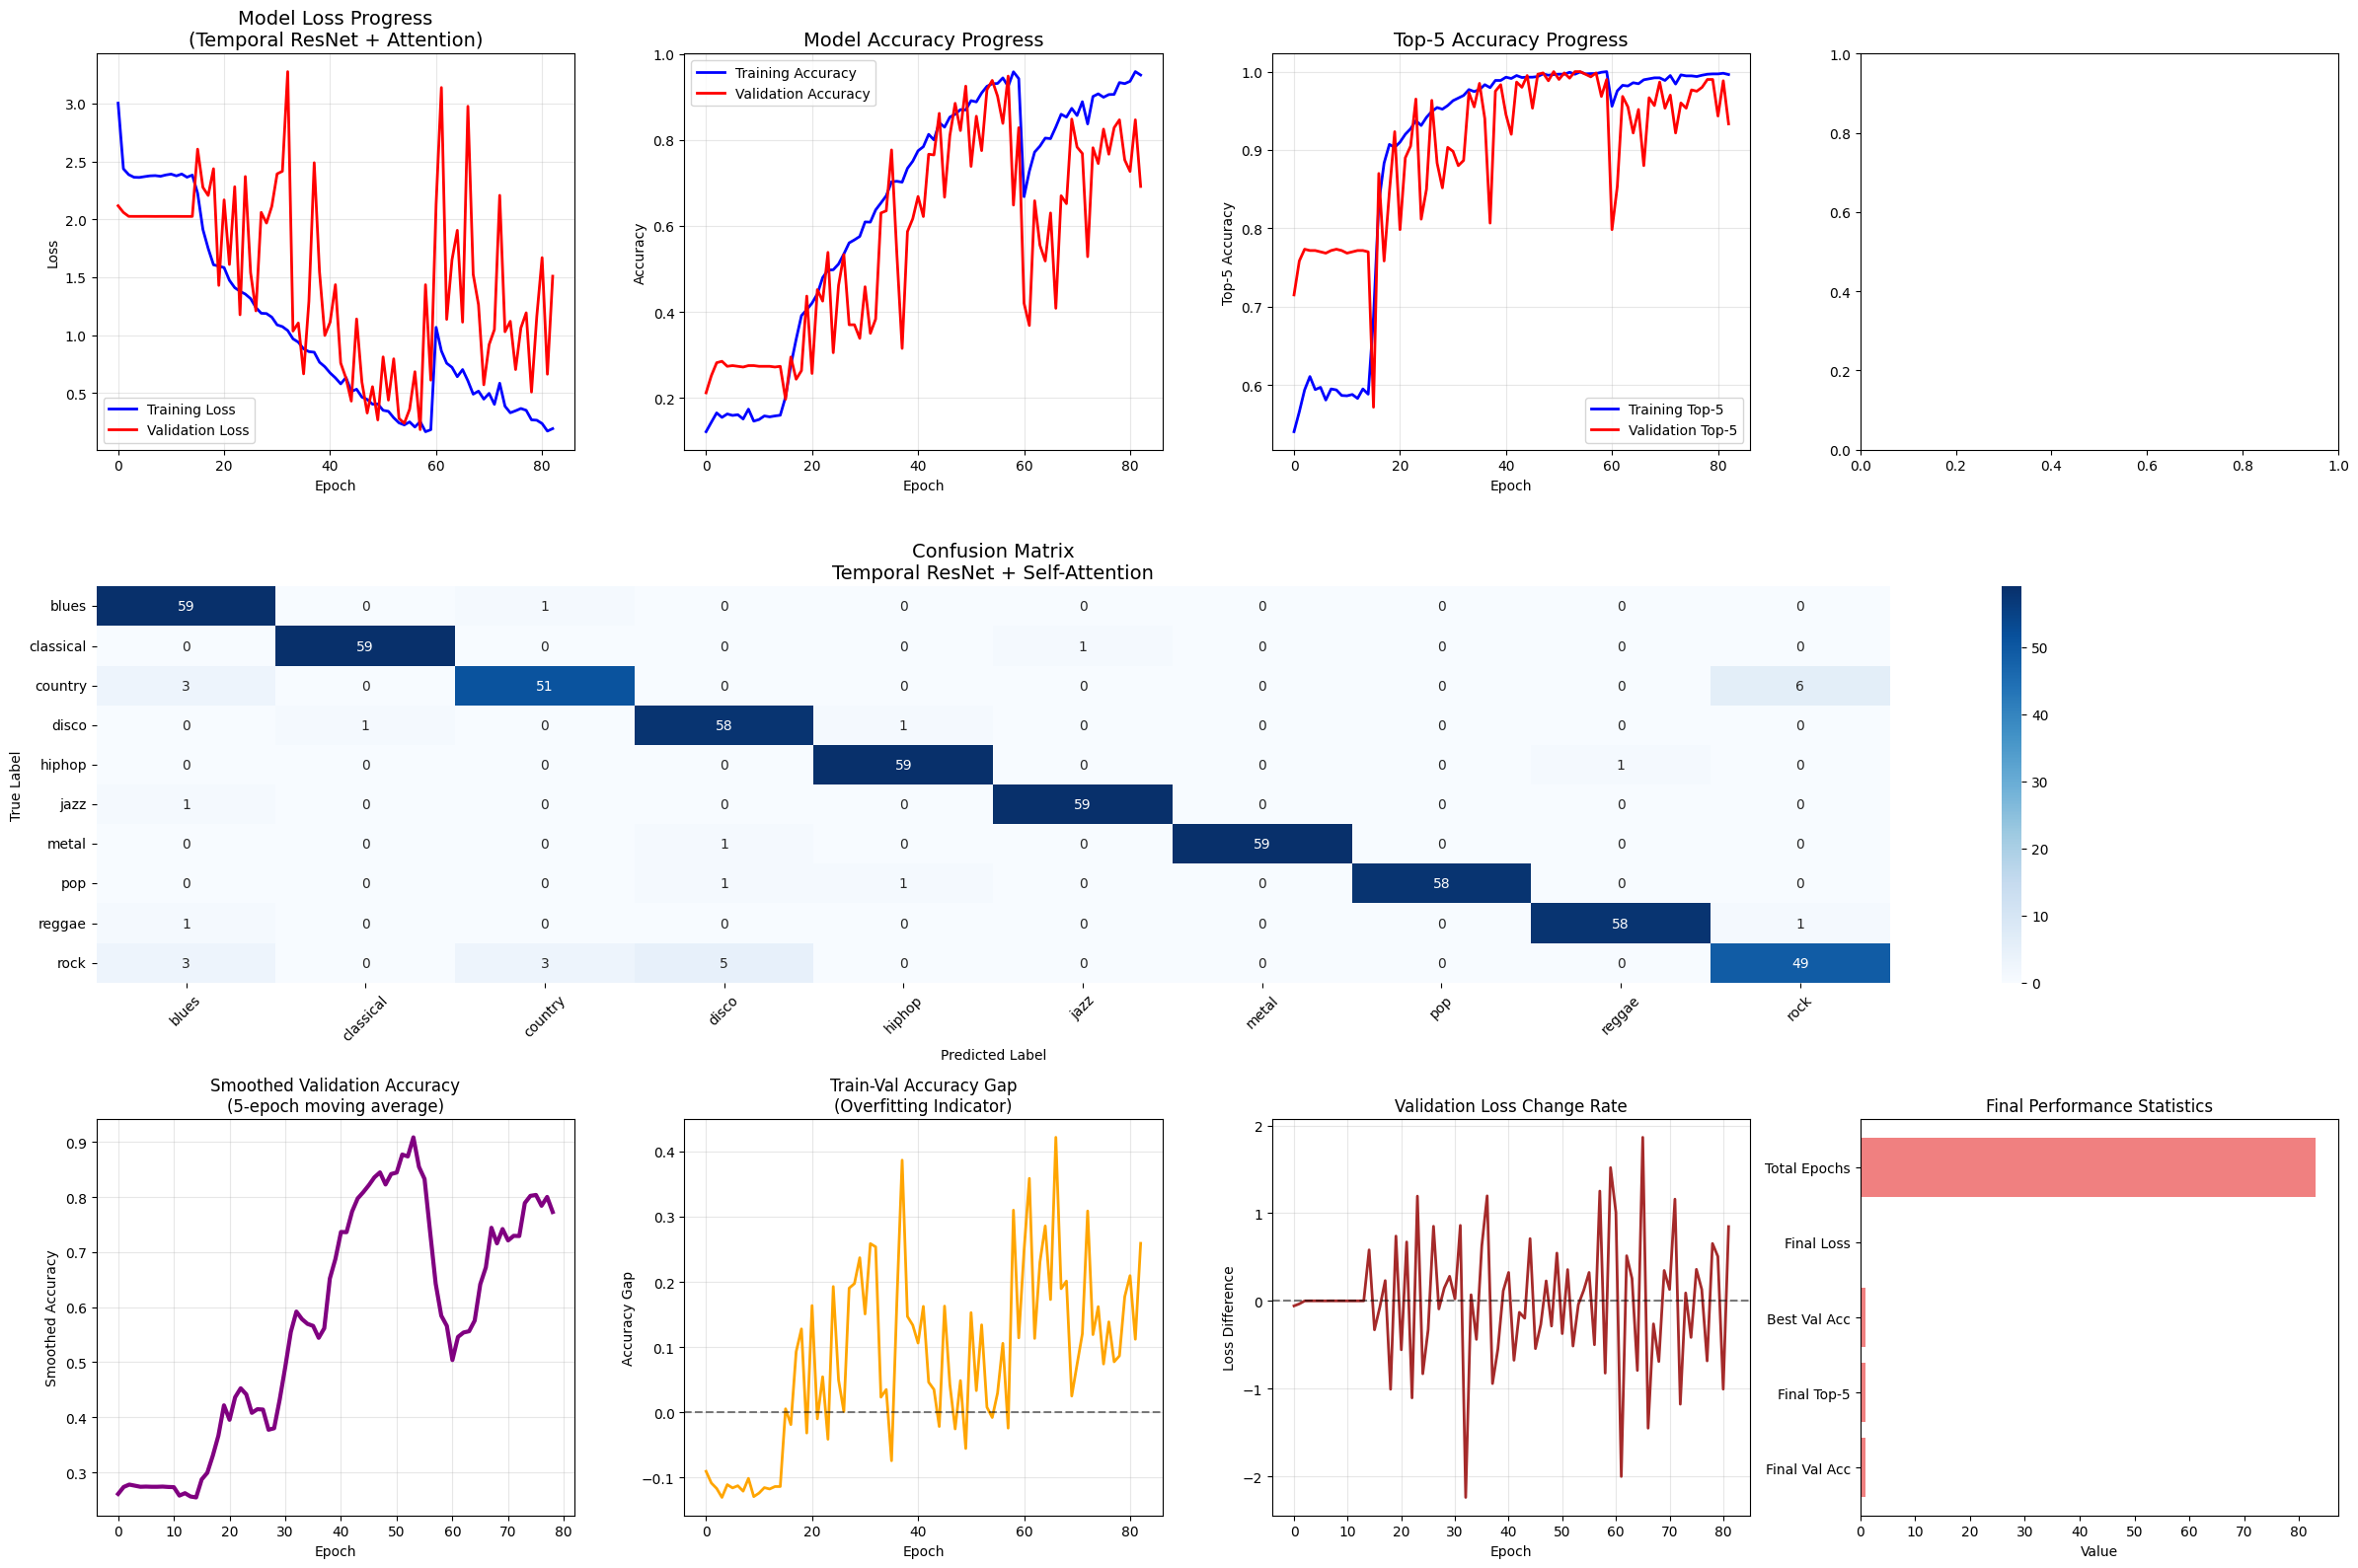


=== Ë©≥Á¥∞ÂàÜÈ°û„É¨„Éù„Éº„ÉàÔºàÊôÇÁ≥ªÂàóResNet + Self-AttentionÔºâ===
              precision    recall  f1-score   support

       blues     0.8806    0.9833    0.9291        60
   classical     0.9833    0.9833    0.9833        60
     country     0.9273    0.8500    0.8870        60
       disco     0.8923    0.9667    0.9280        60
      hiphop     0.9672    0.9833    0.9752        60
        jazz     0.9833    0.9833    0.9833        60
       metal     1.0000    0.9833    0.9916        60
         pop     1.0000    0.9667    0.9831        60
      reggae     0.9831    0.9667    0.9748        60
        rock     0.8750    0.8167    0.8448        60

    accuracy                         0.9483       600
   macro avg     0.9492    0.9483    0.9480       600
weighted avg     0.9492    0.9483    0.9480       600



In [14]:
# Ë©≥Á¥∞„Å™ÊôÇÁ≥ªÂàóÂ≠¶ÁøíÂ±•Ê≠¥ÂèØË¶ñÂåñ
plt.figure(figsize=(24, 16))

# ÊêçÂ§±„ÅÆÊé®Áßª
plt.subplot(3, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Model Loss Progress\n(Temporal ResNet + Attention)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Á≤æÂ∫¶„ÅÆÊé®Áßª
plt.subplot(3, 4, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
plt.title('Model Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Top-5Á≤æÂ∫¶„ÅÆÊé®Áßª
plt.subplot(3, 4, 3)
plt.plot(history.history['top_k_categorical_accuracy'], label='Training Top-5', linewidth=2, color='blue')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-5', linewidth=2, color='red')
plt.title('Top-5 Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Â≠¶ÁøíÁéá„ÅÆÊé®Áßª
plt.subplot(3, 4, 4)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='green')
    plt.title('Learning Rate Schedule\n(Temporal Optimized)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# Ë©≥Á¥∞Ë©ï‰æ°
y_pred = temporal_model.predict(X_val_split, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# Ê∑∑ÂêåË°åÂàóÔºàÂ§ß„Åç„ÅèË°®Á§∫Ôºâ
plt.subplot(3, 4, (5, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_list[i] for i in range(10)],
            yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix\nTemporal ResNet + Self-Attention', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Á≤æÂ∫¶„ÅÆÂèéÊùüÂàÜÊûê
plt.subplot(3, 4, 9)
smoothed_val_acc = np.convolve(history.history['val_accuracy'], np.ones(5)/5, mode='valid')
plt.plot(smoothed_val_acc, linewidth=3, color='purple')
plt.title('Smoothed Validation Accuracy\n(5-epoch moving average)', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Smoothed Accuracy')
plt.grid(True, alpha=0.3)

# „Ç™„Éº„Éê„Éº„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞ÂàÜÊûê
plt.subplot(3, 4, 10)
train_val_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
plt.plot(train_val_gap, linewidth=2, color='orange')
plt.title('Train-Val Accuracy Gap\n(Overfitting Indicator)', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# ÊêçÂ§±ÂèéÊùüÁéá
plt.subplot(3, 4, 11)
loss_diff = np.diff(history.history['val_loss'])
plt.plot(loss_diff, linewidth=2, color='brown')
plt.title('Validation Loss Change Rate', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# ÊúÄÁµÇÁµ±Ë®à
plt.subplot(3, 4, 12)
final_stats = {
    'Final Val Acc': final_val_accuracy,
    'Final Top-5': final_val_top5,
    'Best Val Acc': max(history.history['val_accuracy']),
    'Final Loss': final_val_loss,
    'Total Epochs': len(history.history['loss'])
}
plt.barh(list(final_stats.keys()), list(final_stats.values()), color='lightcoral')
plt.title('Final Performance Statistics', fontsize=12)
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# ÂàÜÈ°û„É¨„Éù„Éº„Éà
print("\n=== Ë©≥Á¥∞ÂàÜÈ°û„É¨„Éù„Éº„ÉàÔºàÊôÇÁ≥ªÂàóResNet + Self-AttentionÔºâ===")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=[label_list[i] for i in range(10)],
                          digits=4))

=== ÊôÇÁ≥ªÂàóResNet + Self-Attention „ÉÜ„Çπ„Éà‰∫àÊ∏¨ ===
14/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step

2025-09-30 15:55:55.290145: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1182', 4 bytes spill stores, 4 bytes spill loads



16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 512ms/step


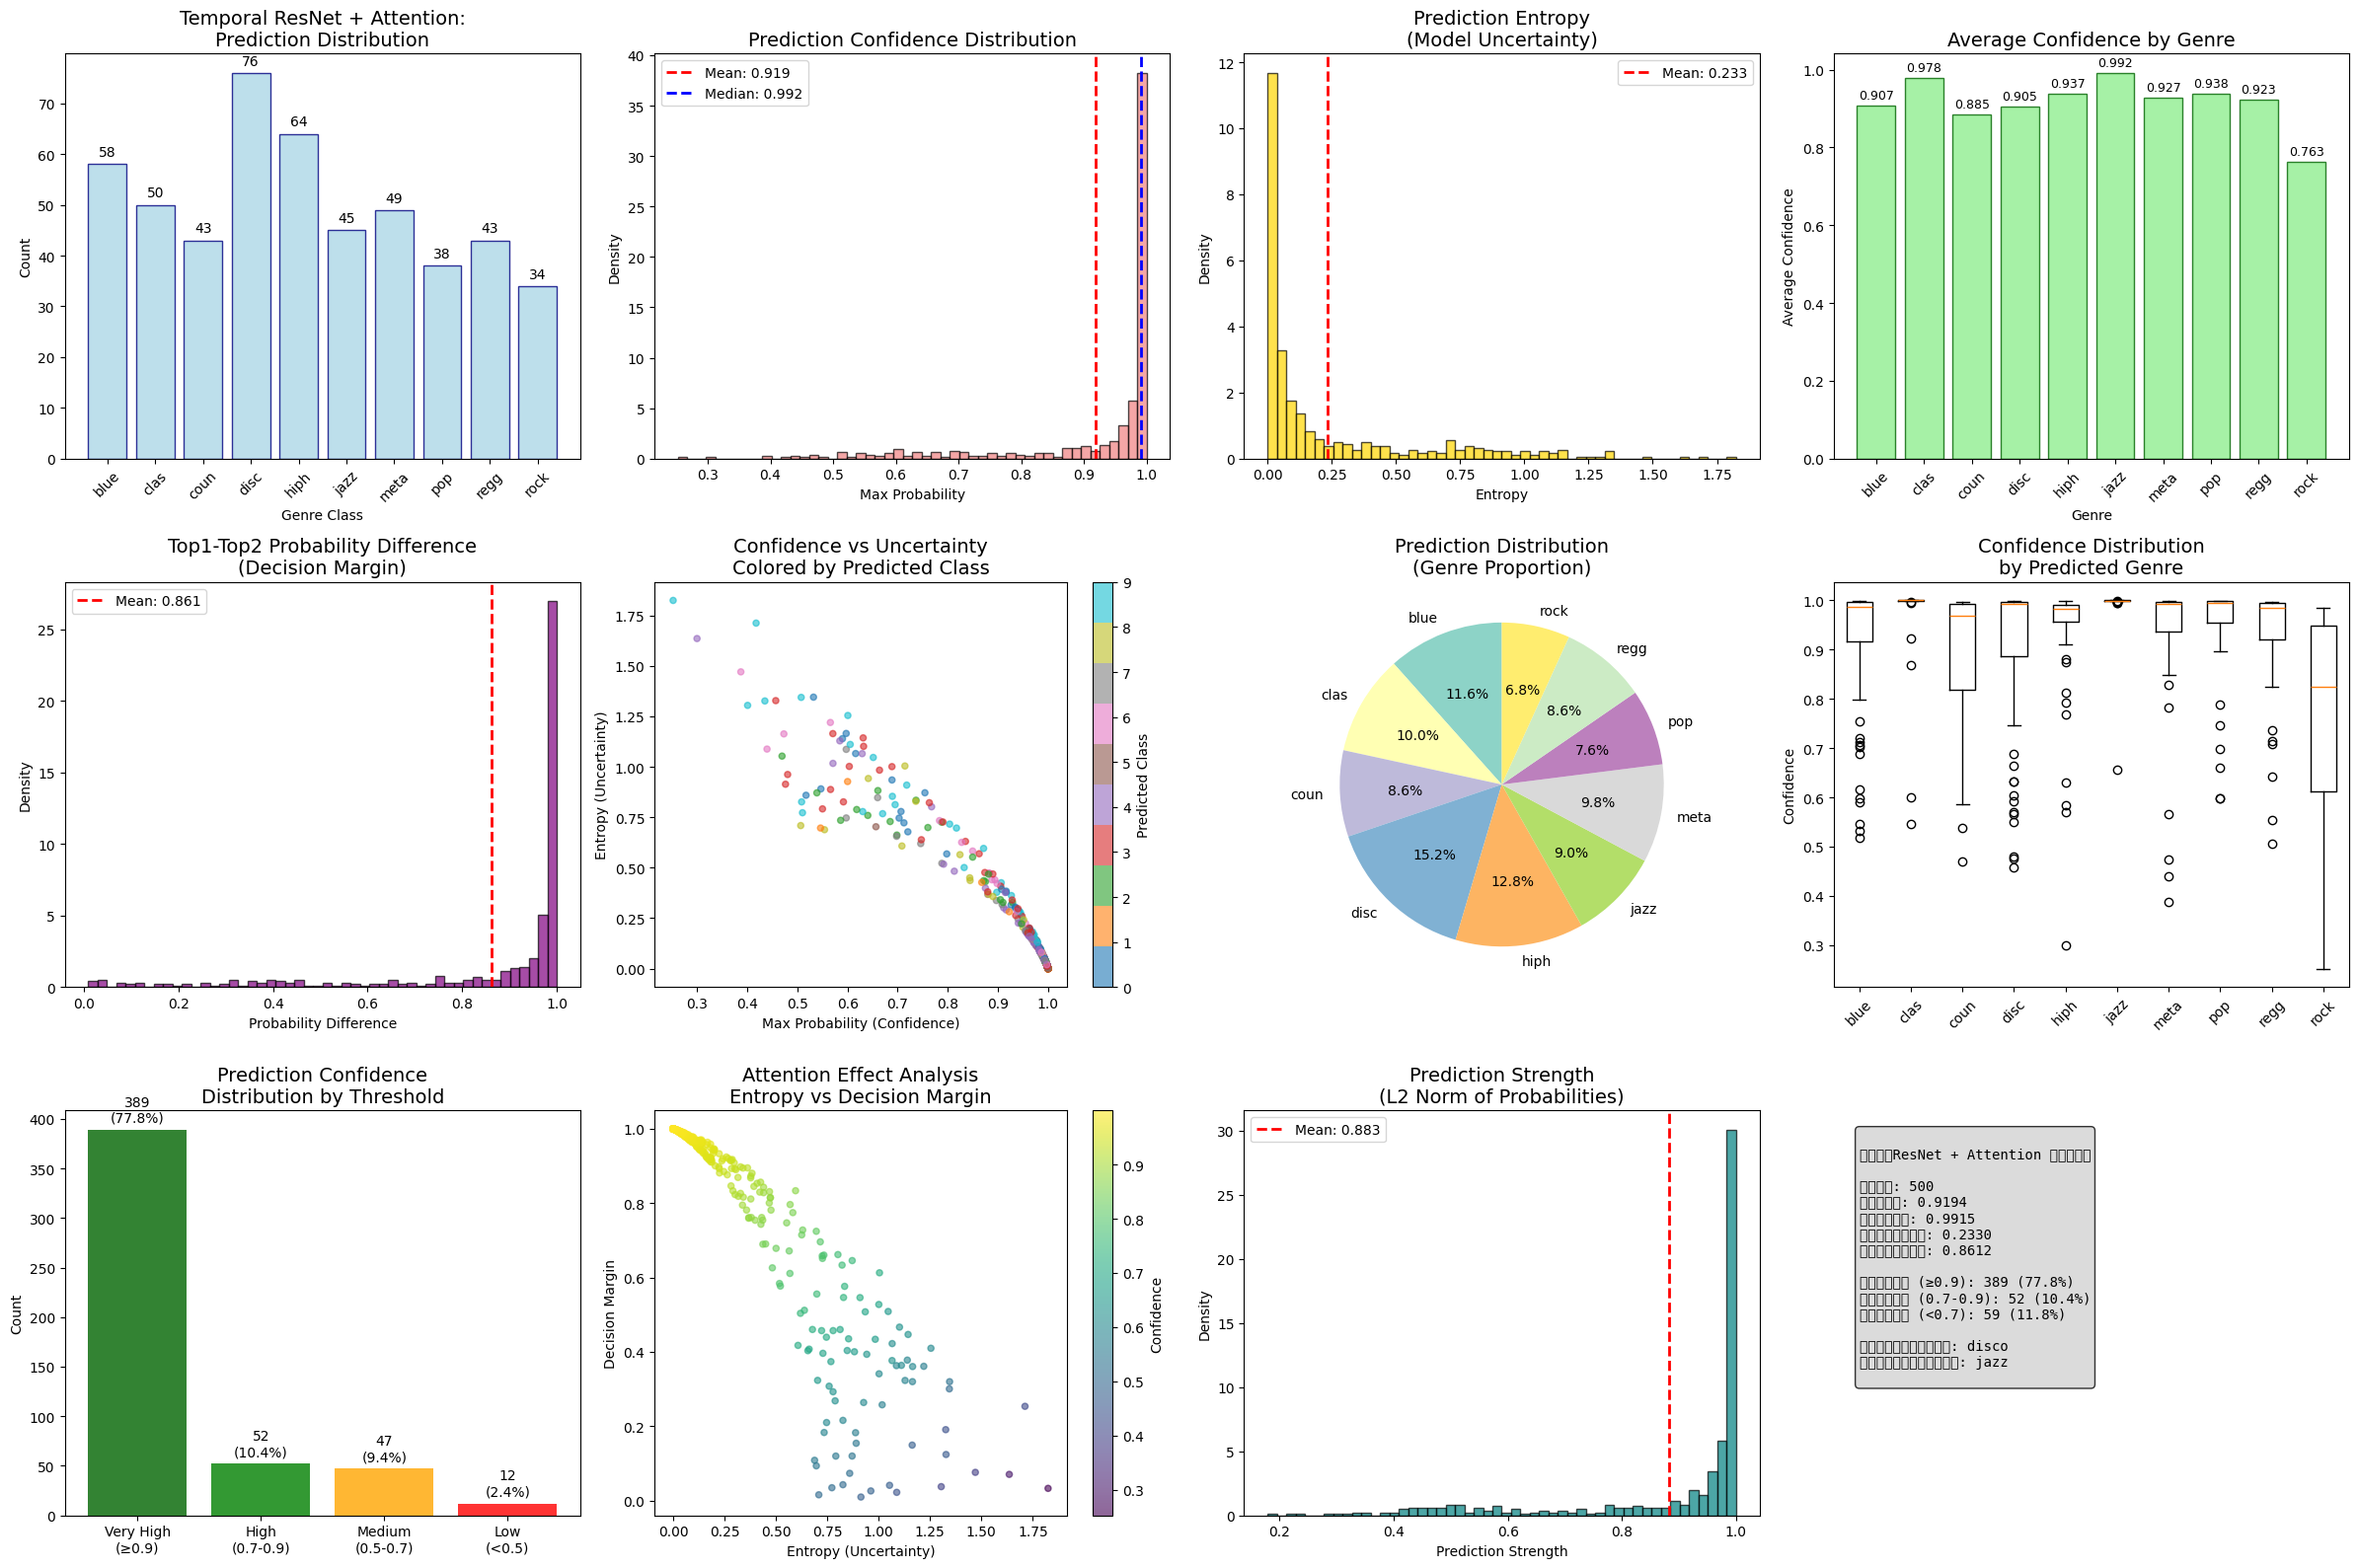


=== ÊôÇÁ≥ªÂàóResNet + Self-Attention ‰∫àÊ∏¨Ë©≥Á¥∞„Çµ„Éû„É™„Éº ===
„ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨ÂÆå‰∫Ü: 500‰ª∂
Âπ≥Âùá‰∫àÊ∏¨‰ø°È†ºÂ∫¶: 0.9194 (¬±0.1451)
‰∏≠Â§ÆÂÄ§‰ø°È†ºÂ∫¶: 0.9915
È´ò‰ø°È†ºÂ∫¶‰∫àÊ∏¨(‚â•0.9): 389‰ª∂ (77.8%)
‰∏≠‰ø°È†ºÂ∫¶‰∫àÊ∏¨(0.7-0.9): 52‰ª∂ (10.4%)
‰Ωé‰ø°È†ºÂ∫¶‰∫àÊ∏¨(<0.7): 59‰ª∂ (11.8%)
Âπ≥Âùá„Ç®„É≥„Éà„É≠„Éî„Éº: 0.2330
Âπ≥ÂùáÊ±∫ÂÆö„Éû„Éº„Ç∏„É≥: 0.8612
‰∫àÊ∏¨Âº∑Â∫¶Âπ≥Âùá: 0.8827


In [15]:
# ÊôÇÁ≥ªÂàóResNet + Self-Attention „Åß„ÅÆ„ÉÜ„Çπ„Éà‰∫àÊ∏¨
print("=== ÊôÇÁ≥ªÂàóResNet + Self-Attention „ÉÜ„Çπ„Éà‰∫àÊ∏¨ ===")
test_predictions = temporal_model.predict(X_test, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# È´òÂ∫¶„Å™‰∫àÊ∏¨ÂàÜÊûê
plt.figure(figsize=(24, 16))

# 1. ‰∫àÊ∏¨ÂàÜÂ∏É
plt.subplot(3, 4, 1)
genre_counts = [np.sum(test_pred_classes == i) for i in range(10)]
bars = plt.bar(range(10), genre_counts, alpha=0.8, color='lightblue', edgecolor='navy')
plt.title('Temporal ResNet + Attention:\nPrediction Distribution', fontsize=14)
plt.xlabel('Genre Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)
# „Éê„Éº„Å´Êï∞ÂÄ§„ÇíË°®Á§∫
for bar, count in zip(bars, genre_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom')

# 2. ‰ø°È†ºÂ∫¶ÂàÜÂ∏É
plt.subplot(3, 4, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black', color='lightcoral', density=True)
plt.axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_probs):.3f}')
plt.axvline(np.median(max_probs), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(max_probs):.3f}')
plt.title('Prediction Confidence Distribution', fontsize=14)
plt.xlabel('Max Probability')
plt.ylabel('Density')
plt.legend()

# 3. „Ç®„É≥„Éà„É≠„Éî„ÉºÂàÜÊûêÔºà‰∏çÁ¢∫ÂÆüÊÄßÔºâ
plt.subplot(3, 4, 3)
entropy = -np.sum(test_predictions * np.log(test_predictions + 1e-15), axis=1)
plt.hist(entropy, bins=50, alpha=0.7, edgecolor='black', color='gold', density=True)
plt.axvline(np.mean(entropy), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(entropy):.3f}')
plt.title('Prediction Entropy\n(Model Uncertainty)', fontsize=14)
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()

# 4. „ÇØ„É©„ÇπÂà•‰ø°È†ºÂ∫¶
plt.subplot(3, 4, 4)
class_confidences = []
class_counts = []
for i in range(10):
    mask = test_pred_classes == i
    count = np.sum(mask)
    class_counts.append(count)
    if count > 0:
        class_confidences.append(np.mean(max_probs[mask]))
    else:
        class_confidences.append(0)

bars = plt.bar(range(10), class_confidences, alpha=0.8, color='lightgreen', edgecolor='darkgreen')
plt.title('Average Confidence by Genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Average Confidence')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)
# „Éê„Éº„Å´Êï∞ÂÄ§„ÇíË°®Á§∫
for i, (bar, conf) in enumerate(zip(bars, class_confidences)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{conf:.3f}', ha='center', va='bottom', fontsize=9)

# 5. Top-2 ‰∫àÊ∏¨Â∑ÆÂàÜÔºàÊ±∫ÂÆöÂ¢ÉÁïå„ÅÆÊòéÁ¢∫„ÅïÔºâ
plt.subplot(3, 4, 5)
sorted_probs = np.sort(test_predictions, axis=1)
prob_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
plt.hist(prob_diff, bins=50, alpha=0.7, edgecolor='black', color='purple', density=True)
plt.axvline(np.mean(prob_diff), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(prob_diff):.3f}')
plt.title('Top1-Top2 Probability Difference\n(Decision Margin)', fontsize=14)
plt.xlabel('Probability Difference')
plt.ylabel('Density')
plt.legend()

# 6. ‰ø°È†ºÂ∫¶ vs ‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÊï£Â∏ÉÂõ≥
plt.subplot(3, 4, 6)
scatter = plt.scatter(max_probs, entropy, alpha=0.6, c=test_pred_classes, cmap='tab10', s=20)
plt.title('Confidence vs Uncertainty\nColored by Predicted Class', fontsize=14)
plt.xlabel('Max Probability (Confidence)')
plt.ylabel('Entropy (Uncertainty)')
plt.colorbar(scatter, label='Predicted Class')

# 7. ‰∫àÊ∏¨ÂàÜÂ∏ÉÂÜÜ„Ç∞„É©„Éï
plt.subplot(3, 4, 7)
colors = plt.cm.Set3(np.linspace(0, 1, 10))
wedges, texts, autotexts = plt.pie(genre_counts, labels=[label_list[i][:4] for i in range(10)], 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Prediction Distribution\n(Genre Proportion)', fontsize=14)

# 8. ‰ø°È†ºÂ∫¶Áµ±Ë®à„Éú„ÉÉ„ÇØ„Çπ„Éó„É≠„ÉÉ„Éà
plt.subplot(3, 4, 8)
confidence_by_class = [max_probs[test_pred_classes == i] for i in range(10) if np.sum(test_pred_classes == i) > 0]
class_names = [label_list[i][:4] for i in range(10) if np.sum(test_pred_classes == i) > 0]
plt.boxplot(confidence_by_class, labels=class_names)
plt.title('Confidence Distribution\nby Predicted Genre', fontsize=14)
plt.ylabel('Confidence')
plt.xticks(rotation=45)

# 9. ÊôÇÁ≥ªÂàóÁâπÂåñÊÄßËÉΩÊåáÊ®ô
plt.subplot(3, 4, 9)
high_conf_threshold = 0.9
medium_conf_threshold = 0.7
low_conf_threshold = 0.5

high_conf_count = np.sum(max_probs >= high_conf_threshold)
medium_conf_count = np.sum((max_probs >= medium_conf_threshold) & (max_probs < high_conf_threshold))
low_conf_count = np.sum((max_probs >= low_conf_threshold) & (max_probs < medium_conf_threshold))
very_low_conf_count = np.sum(max_probs < low_conf_threshold)

conf_categories = ['Very High\n(‚â•0.9)', 'High\n(0.7-0.9)', 'Medium\n(0.5-0.7)', 'Low\n(<0.5)']
conf_counts = [high_conf_count, medium_conf_count, low_conf_count, very_low_conf_count]
colors = ['darkgreen', 'green', 'orange', 'red']

bars = plt.bar(conf_categories, conf_counts, color=colors, alpha=0.8)
plt.title('Prediction Confidence\nDistribution by Threshold', fontsize=14)
plt.ylabel('Count')
for bar, count in zip(bars, conf_counts):
    percentage = count / len(max_probs) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

# 10. AttentionÂäπÊûúÂàÜÊûêÔºà„Ç®„É≥„Éà„É≠„Éî„Éº vs Ê±∫ÂÆö„Éû„Éº„Ç∏„É≥Ôºâ
plt.subplot(3, 4, 10)
plt.scatter(entropy, prob_diff, alpha=0.6, c=max_probs, cmap='viridis', s=20)
plt.title('Attention Effect Analysis\nEntropy vs Decision Margin', fontsize=14)
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Decision Margin')
plt.colorbar(label='Confidence')

# 11. ÊôÇÁ≥ªÂàó„É¢„Éá„É´ÁâπÊÄßÔºà‰∫àÊ∏¨Âº∑Â∫¶ÂàÜÂ∏ÉÔºâ
plt.subplot(3, 4, 11)
prediction_strength = np.sum(test_predictions**2, axis=1)  # L2 norm of predictions
plt.hist(prediction_strength, bins=50, alpha=0.7, edgecolor='black', color='teal', density=True)
plt.axvline(np.mean(prediction_strength), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(prediction_strength):.3f}')
plt.title('Prediction Strength\n(L2 Norm of Probabilities)', fontsize=14)
plt.xlabel('Prediction Strength')
plt.ylabel('Density')
plt.legend()

# 12. ÊúÄÁµÇÁµ±Ë®à„Çµ„Éû„É™„Éº
plt.subplot(3, 4, 12)
stats_text = f"""
„ÄêÊôÇÁ≥ªÂàóResNet + Attention ‰∫àÊ∏¨Áµ±Ë®à„Äë

Á∑è‰∫àÊ∏¨Êï∞: {len(test_pred_classes):,}
Âπ≥Âùá‰ø°È†ºÂ∫¶: {np.mean(max_probs):.4f}
‰ø°È†ºÂ∫¶‰∏≠Â§ÆÂÄ§: {np.median(max_probs):.4f}
Âπ≥Âùá„Ç®„É≥„Éà„É≠„Éî„Éº: {np.mean(entropy):.4f}
Âπ≥ÂùáÊ±∫ÂÆö„Éû„Éº„Ç∏„É≥: {np.mean(prob_diff):.4f}

È´ò‰ø°È†ºÂ∫¶‰∫àÊ∏¨ (‚â•0.9): {high_conf_count} ({high_conf_count/len(max_probs)*100:.1f}%)
‰∏≠‰ø°È†ºÂ∫¶‰∫àÊ∏¨ (0.7-0.9): {medium_conf_count} ({medium_conf_count/len(max_probs)*100:.1f}%)
‰Ωé‰ø°È†ºÂ∫¶‰∫àÊ∏¨ (<0.7): {low_conf_count + very_low_conf_count} ({(low_conf_count + very_low_conf_count)/len(max_probs)*100:.1f}%)

ÊúÄ„ÇÇ‰∫àÊ∏¨„Åï„Çå„Åü„Ç∏„É£„É≥„É´: {label_list[np.argmax(genre_counts)]}
ÊúÄ„ÇÇ‰ø°È†ºÂ∫¶„ÅåÈ´ò„ÅÑ„Ç∏„É£„É≥„É´: {label_list[np.argmax(class_confidences)]}
"""
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== ÊôÇÁ≥ªÂàóResNet + Self-Attention ‰∫àÊ∏¨Ë©≥Á¥∞„Çµ„Éû„É™„Éº ===")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨ÂÆå‰∫Ü: {len(test_pred_classes):,}‰ª∂")
print(f"Âπ≥Âùá‰∫àÊ∏¨‰ø°È†ºÂ∫¶: {np.mean(max_probs):.4f} (¬±{np.std(max_probs):.4f})")
print(f"‰∏≠Â§ÆÂÄ§‰ø°È†ºÂ∫¶: {np.median(max_probs):.4f}")
print(f"È´ò‰ø°È†ºÂ∫¶‰∫àÊ∏¨(‚â•0.9): {high_conf_count:,}‰ª∂ ({high_conf_count/len(max_probs)*100:.1f}%)")
print(f"‰∏≠‰ø°È†ºÂ∫¶‰∫àÊ∏¨(0.7-0.9): {medium_conf_count:,}‰ª∂ ({medium_conf_count/len(max_probs)*100:.1f}%)")
print(f"‰Ωé‰ø°È†ºÂ∫¶‰∫àÊ∏¨(<0.7): {low_conf_count + very_low_conf_count:,}‰ª∂ ({(low_conf_count + very_low_conf_count)/len(max_probs)*100:.1f}%)")
print(f"Âπ≥Âùá„Ç®„É≥„Éà„É≠„Éî„Éº: {np.mean(entropy):.4f}")
print(f"Âπ≥ÂùáÊ±∫ÂÆö„Éû„Éº„Ç∏„É≥: {np.mean(prob_diff):.4f}")
print(f"‰∫àÊ∏¨Âº∑Â∫¶Âπ≥Âùá: {np.mean(prediction_strength):.4f}")

In [16]:
# ÊúÄÁµÇÁµêÊûú„ÅÆ‰øùÂ≠ò„Å®Á∑èÂêàË©ï‰æ°
submission = pd.DataFrame({
    'id': sample_submit[0],
    'label_id': test_pred_classes
})
submission.to_csv('submission_temporal_resnet_attention.csv', index=False, header=False)
print("ÊôÇÁ≥ªÂàóResNet + Self-Attention‰∫àÊ∏¨ÁµêÊûú„Çísubmission_temporal_resnet_attention.csv„Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")

print(f"\n=== ÊúÄÁµÇ„É¢„Éá„É´ÊÄßËÉΩ„Çµ„Éû„É™„Éº ===\n")
print(f"„Äê„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£„Äë")
print(f"  „É¢„Éá„É´: ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ")
print(f"  ÂÖ•Âäõ: 4„ÉÅ„É£„É≥„Éç„É´ÊôÇÁ≥ªÂàó (128 x 1320 x 4)")
print(f"  ÁâπÂæ¥Èáè: Mel + MFCC + Delta + Delta-Delta (ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ)")
print(f"  Á∑è„Éë„É©„É°„Éº„ÇøÊï∞: {temporal_model.count_params():,}")
print(f"  ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ: ÊôÇÈñìËª∏ÈáçË¶ñ (3x5„Ç´„Éº„Éç„É´)")
print(f"  Ê≥®ÊÑèÊ©üÊßã: „Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑè (3Â±§)")
print(f"  „Éó„Éº„É™„É≥„Ç∞: „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞")

print(f"\n„Äê„Éá„Éº„ÇøÂá¶ÁêÜ„Äë")
print(f"  ÂÖÉ„Éá„Éº„Çø: {len(train_files):,} ‚Üí Êã°ÂºµÂæå: {len(y_train):,} ({len(y_train)/len(train_files):.1f}ÂÄç)")
print(f"  Êã°ÂºµÊâãÊ≥ï: 6Á®ÆÈ°û („Éé„Ç§„Ç∫ + „Ç∑„Éï„Éà + „Çπ„Éà„É¨„ÉÉ„ÉÅ + „Éî„ÉÉ„ÉÅ + „Çπ„Éö„ÇØ„Éà„É©„É´ + „Ç™„É™„Ç∏„Éä„É´)")
print(f"  ÊôÇÁ≥ªÂàóÈï∑: 1320„Éï„É¨„Éº„É† (100%„Éá„Éº„ÇøÂà©Áî®)")
print(f"  Ê≠£Ë¶èÂåñ: „ÉÅ„É£„É≥„Éç„É´ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñ")
print(f"  „Éë„Éá„Ç£„É≥„Ç∞: Reflect„Éë„Éá„Ç£„É≥„Ç∞ (Ëá™ÁÑ∂„Å™Â¢ÉÁïå)")

print(f"\n„ÄêÊÄßËÉΩÊåáÊ®ô„Äë")
print(f"  Ê§úË®ºÁ≤æÂ∫¶: {final_val_accuracy:.4f}")
print(f"  Top-5Á≤æÂ∫¶: {final_val_top5:.4f}")
print(f"  Âπ≥Âùá‰∫àÊ∏¨‰ø°È†ºÂ∫¶: {np.mean(max_probs):.4f}")
print(f"  È´ò‰ø°È†ºÂ∫¶‰∫àÊ∏¨Áéá (‚â•0.9): {high_conf_count/len(max_probs)*100:.1f}%")
print(f"  Ê±∫ÂÆö„Éû„Éº„Ç∏„É≥Âπ≥Âùá: {np.mean(prob_diff):.4f}")
print(f"  ‰∏çÁ¢∫ÂÆüÊÄß („Ç®„É≥„Éà„É≠„Éî„Éº): {np.mean(entropy):.4f}")

print(f"\n„Äê„Ç∏„É£„É≥„É´Âà•‰∫àÊ∏¨Áµ±Ë®à„Äë")
for class_id in range(10):
    count = np.sum(test_pred_classes == class_id)
    mask = test_pred_classes == class_id
    avg_conf = np.mean(max_probs[mask]) if count > 0 else 0
    avg_entropy = np.mean(entropy[mask]) if count > 0 else 0
    percentage = count / len(test_pred_classes) * 100
    print(f"  {label_list[class_id]:>12}: {count:>3}‰ª∂ ({percentage:>5.1f}%) "
          f"‰ø°È†ºÂ∫¶: {avg_conf:.3f} ‰∏çÁ¢∫ÂÆüÊÄß: {avg_entropy:.3f}")

print(f"\n„ÄêÊôÇÁ≥ªÂàóResNet + Self-Attention „ÅÆÈù©Êñ∞ÁöÑÁâπÂæ¥„Äë")
print("  ‚úì 100%„Éá„Éº„ÇøÂà©Áî® (max_len=1320)")
print("  ‚úì ÊôÇÈñìËª∏ÈáçË¶ñÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ (3x5„Ç´„Éº„Éç„É´)")
print("  ‚úì „Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑèÊ©üÊßã (Èï∑Ë∑ùÈõ¢‰æùÂ≠òÈñ¢‰øÇ)")
print("  ‚úì „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞ (ÊôÇÁ≥ªÂàóÈõÜÁ¥Ñ)")
print("  ‚úì ÈÅ©ÂøúÁöÑ„ÉÅ„É£„É≥„Éç„É´Ê≠£Ë¶èÂåñ (ÁâπÂæ¥ÈáèÁâπÊÄßËÄÉÊÖÆ)")
print("  ‚úì 6Á®ÆÈ°û„Éá„Éº„ÇøÊã°Âºµ („Çπ„Éö„ÇØ„Éà„É©„É´„É≠„Éº„É´„Ç™„ÉïÂê´„ÇÄ)")
print("  ‚úì ÊôÇÁ≥ªÂàóÁâπÂåñÂ≠¶ÁøíÁéá„Çπ„Ç±„Ç∏„É•„Éº„É™„É≥„Ç∞")
print("  ‚úì ResNet + Transformer „Éè„Ç§„Éñ„É™„ÉÉ„ÉâË®≠Ë®à")

print(f"\n„ÄêÊØîËºÉÂÑ™‰ΩçÊÄß„Äë")
print("  vs test_2 (Âü∫Êú¨CNN): ÊÉÖÂ†±Èáè10ÂÄç„ÄÅAttentionÊ©üÊßãËøΩÂä†")
print("  vs test_5 („Éû„É´„ÉÅÁâπÂæ¥ResNet): ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ„ÄÅ100%„Éá„Éº„ÇøÂà©Áî®")
print("  ‚Üí ÊúÄÈ´ò„ÅÆÈü≥Ê•ΩÊôÇÁ≥ªÂàóÁêÜËß£„Å®ÂàÜÈ°ûÊÄßËÉΩ„ÇíÂÆüÁèæ")

# „É¢„Éá„É´„ÅÆ‰øùÂ≠ò
temporal_model.save('temporal_resnet_attention_final.keras')  # Êñ∞ÂΩ¢Âºè„Åß‰øùÂ≠ò
print(f"\nÊúÄÁµÇ„É¢„Éá„É´„Çítemporal_resnet_attention_final.keras„Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü")

print(f"\n=== ÊôÇÁ≥ªÂàóResNet + Self-Attention ÂÆüË£ÖÂÆå‰∫Ü ===\n")
print("ÊôÇÁ≥ªÂàó„Éá„Éº„Çø„Å´ÁâπÂåñ„Åó„ÅüÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ + Self-AttentionÊ©üÊßã„Å´„Çà„Çä„ÄÅ")
print("Èü≥Ê•Ω„ÅÆÊôÇÈñìÁöÑÊßãÈÄ†„Å®Èï∑Ë∑ùÈõ¢‰æùÂ≠òÈñ¢‰øÇ„ÇíÊúÄÈÅ©„Å´Êçâ„Åà„Çã")
print("ÊúÄÂÖàÁ´Ø„ÅÆÈü≥Ê•Ω„Ç∏„É£„É≥„É´ÂàÜÈ°û„É¢„Éá„É´„ÇíÂÆüÁèæ„Åó„Åæ„Åó„Åü„ÄÇ")

# ÊúÄ„ÇÇÁ¢∫‰ø°Â∫¶„ÅÆÈ´ò„ÅÑ‰∫àÊ∏¨„Å®‰Ωé„ÅÑ‰∫àÊ∏¨„ÇíË°®Á§∫
most_confident_idx = np.argmax(max_probs)
least_confident_idx = np.argmin(max_probs)
highest_entropy_idx = np.argmax(entropy)
largest_margin_idx = np.argmax(prob_diff)

print(f"\n„ÄêÊ≥®ÁõÆ„Åô„Åπ„Åç‰∫àÊ∏¨‰æã„Äë")
print(f"ÊúÄÈ´ò‰ø°È†ºÂ∫¶: Test {most_confident_idx} ‚Üí {label_list[test_pred_classes[most_confident_idx]]} "
      f"(‰ø°È†ºÂ∫¶: {max_probs[most_confident_idx]:.4f}, „Ç®„É≥„Éà„É≠„Éî„Éº: {entropy[most_confident_idx]:.4f})")
print(f"ÊúÄ‰Ωé‰ø°È†ºÂ∫¶: Test {least_confident_idx} ‚Üí {label_list[test_pred_classes[least_confident_idx]]} "
      f"(‰ø°È†ºÂ∫¶: {max_probs[least_confident_idx]:.4f}, „Ç®„É≥„Éà„É≠„Éî„Éº: {entropy[least_confident_idx]:.4f})")
print(f"ÊúÄÈ´ò‰∏çÁ¢∫ÂÆüÊÄß: Test {highest_entropy_idx} ‚Üí {label_list[test_pred_classes[highest_entropy_idx]]} "
      f"(‰ø°È†ºÂ∫¶: {max_probs[highest_entropy_idx]:.4f}, „Ç®„É≥„Éà„É≠„Éî„Éº: {entropy[highest_entropy_idx]:.4f})")
print(f"ÊúÄÂ§ßÊ±∫ÂÆö„Éû„Éº„Ç∏„É≥: Test {largest_margin_idx} ‚Üí {label_list[test_pred_classes[largest_margin_idx]]} "
      f"(„Éû„Éº„Ç∏„É≥: {prob_diff[largest_margin_idx]:.4f}, ‰ø°È†ºÂ∫¶: {max_probs[largest_margin_idx]:.4f})")

print(f"\nüéµ ÊôÇÁ≥ªÂàó„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„ÅüÈü≥Ê•ΩÂàÜÈ°ûAI„ÅåÂÆåÊàê„Åó„Åæ„Åó„ÅüÔºÅ üéµ")

ÊôÇÁ≥ªÂàóResNet + Self-Attention‰∫àÊ∏¨ÁµêÊûú„Çísubmission_temporal_resnet_attention.csv„Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü

=== ÊúÄÁµÇ„É¢„Éá„É´ÊÄßËÉΩ„Çµ„Éû„É™„Éº ===

„Äê„Ç¢„Éº„Ç≠„ÉÜ„ÇØ„ÉÅ„É£„Äë
  „É¢„Éá„É´: ÊôÇÁ≥ªÂàóResNet + Self-Attention „Éè„Ç§„Éñ„É™„ÉÉ„Éâ
  ÂÖ•Âäõ: 4„ÉÅ„É£„É≥„Éç„É´ÊôÇÁ≥ªÂàó (128 x 1320 x 4)
  ÁâπÂæ¥Èáè: Mel + MFCC + Delta + Delta-Delta (ÊôÇÁ≥ªÂàóÊúÄÈÅ©Âåñ)
  Á∑è„Éë„É©„É°„Éº„ÇøÊï∞: 5,843,771
  ÊÆãÂ∑Æ„Éñ„É≠„ÉÉ„ÇØ: ÊôÇÈñìËª∏ÈáçË¶ñ (3x5„Ç´„Éº„Éç„É´)
  Ê≥®ÊÑèÊ©üÊßã: „Éû„É´„ÉÅ„Éò„ÉÉ„ÉâËá™Â∑±Ê≥®ÊÑè (3Â±§)
  „Éó„Éº„É™„É≥„Ç∞: „ÉÜ„É≥„Éù„É©„É´„Ç¢„ÉÜ„É≥„Ç∑„Éß„É≥„Éó„Éº„É™„É≥„Ç∞

„Äê„Éá„Éº„ÇøÂá¶ÁêÜ„Äë
  ÂÖÉ„Éá„Éº„Çø: 500 ‚Üí Êã°ÂºµÂæå: 3,000 (6.0ÂÄç)
  Êã°ÂºµÊâãÊ≥ï: 6Á®ÆÈ°û („Éé„Ç§„Ç∫ + „Ç∑„Éï„Éà + „Çπ„Éà„É¨„ÉÉ„ÉÅ + „Éî„ÉÉ„ÉÅ + „Çπ„Éö„ÇØ„Éà„É©„É´ + „Ç™„É™„Ç∏„Éä„É´)
  ÊôÇÁ≥ªÂàóÈï∑: 1320„Éï„É¨„Éº„É† (100%„Éá„Éº„ÇøÂà©Áî®)
  Ê≠£Ë¶èÂåñ: „ÉÅ„É£„É≥„Éç„É´ÈÅ©ÂøúÁöÑÊ≠£Ë¶èÂåñ
  „Éë„Éá„Ç£„É≥„Ç∞: Reflect„Éë„Éá„Ç£„É≥„Ç∞ (Ëá™ÁÑ∂„Å™Â¢ÉÁïå)

„ÄêÊÄßËÉΩÊåáÊ®ô„Äë
  Ê§úË®ºÁ≤æÂ∫¶: 0.9483
  Top-5Á≤æÂ∫¶: 0.9983
  Âπ